### .Imports

In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import math
import numpy as np

%pylab inline
pylab.rcParams['figure.figsize'] = (20,12)

Populating the interactive namespace from numpy and matplotlib


### .Constants

In [2]:
DATA_FOLDER = '../data_clean'
IS_DATE = re.compile("^[1-2]{1}[0-9]{3}$")

### .Usefull functions

In [3]:
def getKeysByValue(dictOfElements, valueToFind):
    '''
    find the key of a canton
    '''
    for item  in dictOfElements.items():
        if valueToFind in item[1]:
            return item[0]
            break
    raise NotImplementedError

In [4]:
dict_cantons = dict()
dict_cantons['AA'] = ['Appenzell Rh.-Ext.','Appenzell Ausserrhoden']
dict_cantons['AG'] = ['Argovie','Aargau']
dict_cantons['AI'] = ['Appenzell Rh.-Int.','Appenzell Innerrhoden']
dict_cantons['BE'] = ['Berne', 'Bern', 'Bern / Berne']
dict_cantons['BL'] = ['Bâle-Campagne','Basel-Landschaft']
dict_cantons['BS'] = ['Bâle-Ville','Basel-Stadt']
dict_cantons['FR'] = ['Fribourg', 'Fribourg / Freiburg']
dict_cantons['GE'] = ['Genève', 'Genf']
dict_cantons['GL'] = ['Glaris', 'Glarus']
dict_cantons['GR'] = ['Grisons', 'Graubünden', 'Grigioni', 'Grischun', 'Graubünden / Grigioni / Grischun']
dict_cantons['JU'] = ['Jura']
dict_cantons['LU'] = ['Lucerne', 'Luzern']
dict_cantons['NE'] = ['Neuchâtel']
dict_cantons['NW'] = ['Nidwald', 'Nidwalden']
dict_cantons['OW'] = ['Obwald', 'Obwalden']
dict_cantons['SG'] = ['St. Gall', 'St. Gallen','Saint-Gall']
dict_cantons['SH'] = ['Schaffhouse', 'Schaffhausen']
dict_cantons['SO'] = ['Soleure', 'Solothurn']
dict_cantons['SZ'] = ['Schwytz', 'Schwyz']
dict_cantons['TE'] = ['Tessin', 'Ticino']
dict_cantons['TG'] = ['Thurgovie', 'Thurgau']
dict_cantons['UR'] = ['Uri']
dict_cantons['VS'] = ['Valais', 'Wallis', 'Valais / Wallis']
dict_cantons['VD'] = ['Vaud']
dict_cantons['ZG'] = ['Zoug', 'Zug']
dict_cantons['ZH'] = ['Zurich', 'Zürich']

#### Function to restrict the dataframe to a fix period in term of years

In [5]:
def get_period(df, start=None,end=None):
    columns_to_keep = []
    dates = []
    for elem in df.columns:
        if not IS_DATE.match(elem):
            columns_to_keep.append(elem)
        else:
            dates.append(int(elem))
    if start == None:
        start = np.min(dates)
    if end == None:
        end = np.max(dates)
    
    for date in dates:
        if (date<=end) & (date>=start):
            columns_to_keep.append(str(date))
    
    return df[columns_to_keep]

#### Function to get the age corresponding to the intervales as input

In [6]:
def build_age(intervales,age_max):
    ages_total = []
    for i in range(len(intervales)-1):
        ages = []
        ages.append(intervales[i])
        for k in range(int(intervales[i]),int(intervales[i+1])):
            age = map_int_to_age(k,age_max)
            ages.append(age)
            if(k==100):
                break
        ages_total.append(ages)
    return ages_total

In [7]:
def map_int_to_age(k,age_max):
    if(k != 1 and k<age_max):
        return '{} ans'.format(k)
    if(k == 1):
        return '{} an'.format(k)
    if(k==age_max):
        if (age_max == 100):
            return '{} ans ou plus'.format(age_max)
        else:
            return '{} ans et plus'.format(age_max)

#### Function to describe a dataframe

In [8]:
def describeDf(df,name="DESCRIPTION",level=1):
    print("______________________________ " + name+" ______________________________\n")
    date = []
    if(level==1):
        print("\n")
        for col in df.columns:
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                print("         ATTRIBUTE: "+col)
                print("   "+str(df[col].unique()))
                print("\n")
            else:
                date.append(col)
        print("         VALUES: "+str(date))
        print("\n\n\n")
    else :
        print(df.columns.values)
        print("\n\n\n")

#### Homemade rewriting of the folium

> Since the `choropleth` method in folium is depreciated and doesn't display the `NaN values` right, we decide to add a new function to folium to make choropleth map.

In [3]:
import branca
from folium.folium import color_brewer, StepColormap

class NewMap(folium.Map):

    def color_map(self, data, columns, topo_data, objects,
                  legend, layer_name ='', color_domain=[], fill_opacity=0.8, nan_opacity=0.3,
                  line_weight=1, line_opacity=1, key_on='id',show=True, multiMap=False):

        """
        data: dataframe
        columns: tuple of the column headers of the keys and the data to be used
        topo_data: topojson file
        objects: objects path of your topo json file
        layer_name: Name of the color layer. Put 'None' if you don't want to print any 
                    legend
        color_domain: list of the color scale in legend, it is automatically defined with
                        the minimum and maximum of your data if no list is provided.
        multiMap: bool that informs wether it is possible to change the map interactively or not,
                        if yes, we want that both maps plotted interactively use the same color scale
        """
        
        # Fix the color scale: from yellow to red in our case
        if multiMap==False:
            colorscale = branca.colormap.linear.YlOrRd_09.scale(min(data[columns[1]]),max(data[columns[1]]))
        
        else:            # only for interactive maps with two input choices
            lowLim=min(min(data[columns[1]]), min(data[columns[2]]))   #we select overall min of both sets for the min of color scale
            upLim=max(max(data[columns[1]]), max(data[columns[2]]))    #same for max value of color scale
            colorscale = branca.colormap.linear.YlOrRd_09.scale(lowLim,upLim)
        
        # Redefine the styling function to blacken the NAN entries and color the other 
        # entries with the right color
        def style_function(feature):
            variation = (data[data[columns[0]] == feature[key_on]][columns[1]].values)
            if(variation != variation):
                return {
                'weight': line_weight,
                'opacity': line_opacity,
                'fillOpacity': nan_opacity,
                'color': 'black',
                'fillColor': '#black'
            }
            return {
                'weight': line_weight,
                'opacity': line_opacity,
                'fillOpacity': fill_opacity,
                'color': 'black',
                'fillColor': colorscale(variation)
            }

        # Define the colored layer using the predefine styling function
        geo_json = folium.TopoJson(topo_data,
                                   objects,
                                   style_function = style_function,
                                   name = layer_name,
                                   show=show
                                  )
        
        # Add the colored layer to our map
        self.add_child(geo_json)

        # If you want a color scale legend, add it
        if legend != 'None':
            
            # If the scale is not defined, define it automatically through the minimal
            # and maximal values
            if not color_domain:
                color_domain = np.arange(min(data[columns[1]]), max(data[columns[1]]),\
                                         (max(data[columns[1]])-min(data[columns[1]]))/6)
                
            # Create the legend with the existing function
            brewed = color_brewer('YlOrRd', n=len(color_domain)-1)
            color_scale = StepColormap(
            brewed[0:len(color_domain)-1],    
            index=color_domain,
            vmin=color_domain[0],
            vmax=color_domain[-1],
            caption=legend,
            )
            
            # Add the legend to the map
            self.add_child(color_scale)

### .Load Dataframe

In [9]:
print("Dataframes available:\n\n")
for file in os.listdir(DATA_FOLDER):
    filename = os.fsdecode(file)
    tablename = "df_"+os.path.splitext(os.path.splitext(filename)[0])[0]
    globals()[tablename] = pd.read_csv(DATA_FOLDER + '/' + filename)
    try:
        globals()[tablename] = globals()[tablename].drop(columns=['Unnamed: 0'])
    except:
        pass
    describeDf(globals()[tablename], name=tablename,level=0)
    

Dataframes available:


______________________________ df_Accident_cantons ______________________________

['canton_index' 'canton' 'gravite_index' 'gravite' 'ruralite_index'
 'ruralite' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '2000'
 '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010'
 '2011' '2012' '2013' '2014' '2015' '2016' '2017']




______________________________ df_Accident_circonstances ______________________________

['mois_index' 'mois' 'day_index' 'day' 'hours_index' 'hours'
 'gravite_index' 'gravite' 'ruralite_index' 'ruralite' 'contexte_index'
 'contexte' 'circonstance_index' 'circonstance' '1992' '1993' '1994'
 '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003' '2004'
 '2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015' '2016' '2017']




______________________________ df_Accident_objets ______________________________

['voiture_index' 'voiture' 'age_index' 'age' 'sexe_index' 'sexe'
 'annee_permis_in

In [23]:
 df_Accident_cantons['2011'].sum()

18990.0

## A. Test on the dataset

In this section, unknown values were not excluded to avoid asymetric operations on different datasets. 

In [24]:
reg = re.compile('201[1-7]')

#test dataset with cantons
df_acc_cantons = df_Accident_cantons

#only taking years from 2010 to 2017
toDrop = []
for elem in df_acc_cantons.columns:
    if reg.match(elem):
        toDrop.append(elem)
df_acc_cantons = df_acc_cantons.drop(columns=toDrop)

#aggregate groups by gravite 
acc_cantons = df_acc_cantons.groupby(['gravite']).sum().sort_values(['2010'], ascending=False)\
            [[col for col in df_acc_cantons.columns if IS_DATE.match(col)]]
display(acc_cantons)

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
gravite,,,,,,,,,,,,,,,,,,,
Accidents avec blessés légers,15755.0,15933.0,16967.0,16409.0,15504.0,16084.0,16207.0,17311.0,17754.0,17942.0,17866.0,18168.0,17501.0,16719.0,16543.0,16790.0,16034.0,15834.0,15214.0
Accidents avec blessés graves,6769.0,6258.0,5923.0,5981.0,5512.0,5438.0,5475.0,5574.0,5428.0,5458.0,5305.0,5173.0,4912.0,4614.0,4608.0,4760.0,4366.0,4337.0,4082.0
Accidents mortels,748.0,661.0,637.0,640.0,562.0,553.0,550.0,549.0,555.0,496.0,476.0,499.0,478.0,373.0,340.0,361.0,336.0,335.0,313.0


In [25]:
#test dataset with circonstances
df_acc_circo = df_Accident_circonstances

#only taking years from 2010 to 2017
toDrop = []
for elem in df_acc_circo.columns:
    if reg.match(elem):
        toDrop.append(elem)
df_acc_circo = df_acc_circo.drop(columns=toDrop)

#aggregate groups by gravite
acc_circo = df_acc_circo.groupby(['gravite']).sum().sort_values(['2010'], ascending=False)\
            [[col for col in df_acc_circo.columns if IS_DATE.match(col)]]
display(acc_circo)

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
gravite,,,,,,,,,,,,,,,,,,,
Accidents avec blessés légers,11423.0,11618.0,12649.0,12012.0,11459.0,11935.0,11848.0,12436.0,12959.0,12809.0,13064.0,13139.0,12573.0,12153.0,12049.0,12303.0,11604.0,11380.0,10605.0
Accidents avec blessés graves,4673.0,4261.0,4046.0,4065.0,3695.0,3634.0,3570.0,3661.0,3554.0,3557.0,3438.0,3205.0,2995.0,2940.0,2912.0,3068.0,2762.0,2747.0,2460.0
Accidents mortels,402.0,377.0,377.0,361.0,304.0,302.0,311.0,287.0,316.0,266.0,229.0,272.0,271.0,191.0,192.0,184.0,189.0,191.0,174.0


In [26]:
#test dataset with route type
df_acc_routeType = df_Accident_type_route

#only taking years from 2010 to 2017
toDrop = []
for elem in df_acc_routeType.columns:
    if reg.match(elem):
        toDrop.append(elem)
df_acc_routeType = df_acc_routeType.drop(columns=toDrop)

#aggregate groups by gravite
acc_routeType = df_acc_routeType.groupby(['gravite']).sum().sort_values(['2010'],ascending=False)\
            [[col for col in df_acc_routeType.columns if IS_DATE.match(col)]]
display(acc_routeType)

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
gravite,,,,,,,,,,,,,,,,,,,
Accidents avec blessés légers,15755.0,15933.0,16967.0,16409.0,15504.0,16084.0,16207.0,17311.0,17754.0,17942.0,17866.0,18168.0,17501.0,16719.0,16543.0,16790.0,16034.0,15834.0,15214.0
Accidents avec blessés graves,6769.0,6258.0,5923.0,5981.0,5512.0,5438.0,5475.0,5574.0,5428.0,5458.0,5305.0,5173.0,4912.0,4614.0,4608.0,4760.0,4366.0,4337.0,4082.0
Accidents mortels,748.0,661.0,637.0,640.0,562.0,553.0,550.0,549.0,555.0,496.0,476.0,499.0,478.0,373.0,340.0,361.0,336.0,335.0,313.0


In [27]:
#test dataset with objects
df_acc_objet = df_Accident_objets

#only taking years from 2010 to 2017
toDrop = []
for elem in df_acc_objet.columns:
    if reg.match(elem):
        toDrop.append(elem)
df_acc_objet = df_acc_objet.drop(columns=toDrop)

#aggregate groups by gravite 
acc_objet = df_acc_objet.groupby(['gravite']).sum().sort_values(['2010'],ascending=False)\
            [[col for col in df_acc_objet.columns if IS_DATE.match(col)]]
display(acc_objet)

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
gravite,,,,,,,,,,,,,,,,,,,
Accidents avec blessés légers,30149.0,30651.0,33047.0,32067.0,30310.0,31510.0,31686.0,33859.0,34625.0,34814.0,34744.0,35115.0,33672.0,32494.0,32033.0,32442.0,30692.0,30474.0,29117.0
Accidents avec blessés graves,12519.0,11472.0,10803.0,11013.0,10037.0,9966.0,9987.0,10259.0,9868.0,9914.0,9513.0,9156.0,8693.0,8236.0,8264.0,8466.0,7745.0,7685.0,7165.0
Accidents mortels,1321.0,1232.0,1163.0,1135.0,1009.0,972.0,1015.0,996.0,1008.0,902.0,842.0,945.0,860.0,637.0,627.0,627.0,624.0,583.0,564.0


> We know that in 2017, there were 17'799 accidents causing body injuries in Switzerland. Therefore, it means that cantons and routeType datasets are correct! 
However, the dataset of circomstances is lacking of values (missing ~1/2) and the one about objects is containing too much (round 2 times more accidents). **This might be explained by the fact that multiple objects are involved in one accident.**

In [28]:
#aggregate objets dataset in groups by vehicle type
acc_objet = df_acc_objet.groupby(['voiture']).sum().sort_values(['2010'],ascending=False)\
            [[col for col in df_acc_objet.columns if IS_DATE.match(col)]]
display(acc_objet)

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
voiture,,,,,,,,,,,,,,,,,,,
Voiture de tourisme,27180.0,26961.0,28208.0,28134.0,26318.0,26636.0,27603.0,29248.0,29617.0,29919.0,29466.0,29087.0,27639.0,26246.0,25701.0,25958.0,24392.0,23912.0,22889.0
Cycle,3520.0,3593.0,3900.0,3637.0,3586.0,3869.0,3510.0,3546.0,3503.0,3358.0,3394.0,3579.0,3390.0,3373.0,3417.0,3513.0,3473.0,3558.0,3373.0
Piéton,3157.0,3052.0,2993.0,3165.0,2913.0,2888.0,2905.0,3043.0,3003.0,2808.0,2769.0,2645.0,2634.0,2514.0,2653.0,2679.0,2526.0,2635.0,2648.0
Motocycle de plus de 125 cm3,2068.0,2066.0,2071.0,1950.0,1686.0,1896.0,1640.0,1768.0,1801.0,1856.0,1832.0,2302.0,2268.0,2290.0,2239.0,2422.0,2134.0,2376.0,2182.0
Véhicule de transport de choses,2440.0,2391.0,2408.0,2516.0,2271.0,2270.0,2314.0,2588.0,2545.0,2473.0,2411.0,2406.0,2279.0,2285.0,2403.0,2313.0,2091.0,2033.0,2049.0
Motocycle jusqu'à 125 cm3,1999.0,1887.0,1855.0,1635.0,1567.0,1748.0,1620.0,1582.0,1621.0,1694.0,1605.0,1664.0,1921.0,1857.0,1985.0,2014.0,1965.0,1975.0,1553.0
Motocycle léger,270.0,276.0,272.0,259.0,267.0,361.0,560.0,802.0,1088.0,1266.0,1505.0,1430.0,1097.0,888.0,746.0,742.0,690.0,531.0,622.0
Cyclomoteur,2239.0,2001.0,2162.0,1867.0,1740.0,1721.0,1546.0,1475.0,1347.0,1225.0,1165.0,1038.0,962.0,858.0,781.0,851.0,784.0,698.0,616.0
Autre et inconnu,552.0,536.0,611.0,483.0,502.0,528.0,459.0,528.0,479.0,529.0,461.0,486.0,453.0,497.0,456.0,540.0,539.0,510.0,454.0


> In previous table, we can see that in 2017, more cars were involved in accidents than the total number of accidents (18981>17799). This illustrates that many vehicles are implied in accidents. 

In [29]:
totCrash=sum(acc_cantons['2010'])
totObjects = sum(acc_objet['2010'])
objetPerCrash = totObjects/totCrash

print('In average, a crash was involving %.2f objects in 2017.' % objetPerCrash)

In average, a crash was involving 1.88 objects in 2017.


Now let's study the case of circonstances dataset:

In [30]:
#aggregate groups by circonstances
acc_circo = df_acc_circo.groupby(['circonstance']).sum().sort_values(['2010'], ascending=False)\
            [[col for col in df_acc_circo.columns if IS_DATE.match(col)]]
display(acc_circo)

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
circonstance,,,,,,,,,,,,,,,,,,,
Autre facteur d'influence,15441.0,15291.0,16094.0,15570.0,14649.0,15051.0,14853.0,15445.0,15954.0,15776.0,15852.0,15813.0,15058.0,14469.0,14219.0,14711.0,13709.0,13528.0,12446.0
Alcool,980.0,894.0,896.0,787.0,731.0,735.0,798.0,861.0,787.0,763.0,778.0,705.0,654.0,672.0,805.0,720.0,737.0,661.0,658.0
Drogues,40.0,40.0,49.0,42.0,33.0,46.0,40.0,33.0,46.0,41.0,50.0,50.0,57.0,67.0,63.0,57.0,52.0,59.0,63.0
Alcool + droques,15.0,9.0,12.0,18.0,27.0,18.0,16.0,21.0,15.0,26.0,24.0,24.0,27.0,39.0,35.0,27.0,17.0,18.0,28.0
Médicaments,10.0,11.0,12.0,10.0,8.0,14.0,11.0,13.0,17.0,15.0,15.0,13.0,30.0,23.0,17.0,21.0,23.0,32.0,23.0
Alcool + médicaments,5.0,7.0,4.0,6.0,4.0,3.0,6.0,7.0,8.0,6.0,7.0,7.0,8.0,7.0,11.0,10.0,14.0,19.0,17.0
Drogues et médicaments,7.0,3.0,5.0,4.0,5.0,2.0,5.0,3.0,2.0,5.0,4.0,4.0,5.0,6.0,2.0,6.0,2.0,0.0,3.0
Alcool + drogues + médicaments,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0


> Hmmm... it looks like this dataset is incomplete! It provides only 11754 values out of 17799 accidents... Another possibility would be that "Autres facteurs d'influence" doesn't contain "No influence factor" for example. 

In [32]:
#aggregate circo dataset in groups by context
acc_circo = df_acc_circo.groupby(['contexte']).sum().sort_values(['2010'], ascending=False)\
            [[col for col in df_acc_circo.columns if IS_DATE.match(col)]]
display(acc_circo)

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
contexte,,,,,,,,,,,,,,,,,,,
Tamponnement,2937.0,3045.0,3499.0,3620.0,3685.0,3872.0,3968.0,4280.0,4652.0,4595.0,4930.0,5033.0,4796.0,4772.0,4726.0,4818.0,4436.0,4384.0,4061.0
Changement de direction (en obliquant),4717.0,4882.0,5095.0,4759.0,4431.0,4606.0,4532.0,4856.0,4953.0,4952.0,4906.0,4851.0,4676.0,4443.0,4244.0,4491.0,4163.0,4131.0,3887.0
Accident concernant des piétons,2813.0,2691.0,2656.0,2777.0,2565.0,2525.0,2554.0,2601.0,2605.0,2477.0,2382.0,2279.0,2313.0,2206.0,2286.0,2332.0,2219.0,2251.0,2251.0
À une bifurcation sans changement de direction,2609.0,2375.0,2521.0,2249.0,2018.0,2095.0,1991.0,1919.0,1929.0,1878.0,1782.0,1765.0,1601.0,1493.0,1450.0,1457.0,1382.0,1280.0,1058.0
Lors de croisement (longitudinal),1499.0,1454.0,1402.0,1359.0,1137.0,1132.0,1145.0,1157.0,1092.0,1101.0,1083.0,1102.0,1028.0,1002.0,1028.0,976.0,943.0,921.0,833.0
Autre,886.0,834.0,814.0,713.0,696.0,743.0,696.0,742.0,760.0,819.0,821.0,747.0,689.0,646.0,682.0,718.0,729.0,689.0,602.0
Dépassement,922.0,851.0,951.0,855.0,817.0,792.0,732.0,720.0,737.0,688.0,715.0,731.0,631.0,616.0,625.0,656.0,592.0,574.0,465.0
Avec un animal,115.0,124.0,134.0,106.0,109.0,106.0,111.0,109.0,101.0,122.0,112.0,108.0,105.0,106.0,112.0,107.0,91.0,88.0,82.0


> Still the same issue, and 'Autre' is even included... I think there miss values

## B. Analyse on the actor of car accident

> Maybe our previous results are false since it's relative to the population but we don't know the part of the population who has a driver licence. So now let study the pur data. We prepare the dataset to a pourcentage relative to the number of car accident during the year.

In [33]:
df_Accident = df_Accident_objets[(df_Accident_objets.faute_index==1) & (df_Accident_objets.voiture_index==210)]
for column in df_Accident.columns:
    if IS_DATE.match(column):
        df_Accident[column] = df_Accident[column].apply(lambda x: x*100/(df_Accident[column].sum()))

C:\Users\Clementg20\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### B.1. Sexe and Age of drivers

In [34]:
display(df_Accident.groupby(['sexe']).sum().sort_values(['2017'], ascending=False)\
        [[col for col in df_Accident.columns if IS_DATE.match(col)]])

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
sexe,,,,,,,,,,,,,,,,,,,,,
Homme,72.550478,71.591507,70.455072,70.507938,70.061164,69.991251,69.749787,68.984757,68.619270,68.311121,...,63.908187,64.488518,63.897465,63.744292,63.759194,63.543805,62.981812,61.982833,62.231615,61.811600
Femme,25.716410,26.764930,27.860120,27.880954,28.211110,28.215223,28.719786,29.209088,29.723178,30.081756,...,34.028062,33.778706,33.991527,34.056317,34.282059,34.641596,35.040881,35.785408,35.807270,36.309575
Inconnu,1.733112,1.643563,1.684808,1.611108,1.727726,1.793526,1.530426,1.806155,1.657552,1.607123,...,2.063752,1.732777,2.111007,2.199391,1.958746,1.814599,1.977307,2.231760,1.961116,1.878824


In [35]:
display(df_Accident.groupby(['age']).sum().sort_values(['2017'], ascending=False)\
        [[col for col in df_Accident.columns if IS_DATE.match(col)]].head(5))

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
age,,,,,,,,,,,,,,,,,,,,,
21-29 ans,32.362867,30.806574,29.845994,29.105396,27.340942,26.390451,26.497024,26.304285,24.575746,24.599619,...,23.934069,23.458594,22.574855,22.549467,21.410297,21.873717,21.341565,20.849785,20.481826,20.744635
30-39 ans,19.567580,19.933322,21.120889,21.020564,21.596570,21.853518,21.559577,22.530917,21.790607,21.581364,...,17.872224,17.418232,17.175271,16.651446,17.276943,17.415223,16.827966,16.334764,17.100592,17.452383
40-49 ans,13.933535,14.704334,14.578509,14.880778,15.070307,14.554431,15.547188,14.713834,15.295710,15.785642,...,17.647459,17.390397,17.893301,16.849315,17.628718,16.725511,16.385783,16.377682,15.198648,14.935792
50-59 ans,9.655094,10.352693,10.398333,10.914523,10.946466,11.604799,11.387101,11.285591,11.805830,11.132266,...,12.409753,12.588727,12.938896,12.815830,13.383435,13.334428,14.300017,14.909871,14.784446,14.909937
70 ans et plus,5.062060,5.457098,5.679713,5.958170,6.343401,6.749156,6.170290,6.016681,6.833174,6.921268,...,7.982564,8.608212,8.738422,9.634703,9.881676,10.181460,10.737527,11.527897,12.375317,12.548479


In [36]:
display(df_Accident.groupby(['sexe','age']).sum().sort_values(['2017'], ascending=False)\
        [[col for col in df_Accident.columns if IS_DATE.match(col)]].head(5))

1992       1993       1994       1995       1996  \
sexe  age                                                                
Homme 21-29 ans  23.560030  22.272913  21.271422  20.692483  19.307649   
      30-39 ans  14.316765  14.218869  14.404817  14.623001  15.246863   
      40-49 ans   9.775210   9.972510   9.981473  10.176343  10.259159   
      50-59 ans   7.058285   7.498392   7.596109   7.686449   7.667570   
Femme 21-29 ans   8.802837   8.533661   8.574572   8.412912   8.033293   

                      1997       1998       1999       2000       2001  \
sexe  age                                                                
Homme 21-29 ans  18.416448  18.899551  18.349152  17.139313  16.933587   
      30-39 ans  15.223097  14.696951  15.478861  14.083554  14.497704   
      40-49 ans   9.980002  10.737277   9.882082  10.385071  10.549894   
      50-59 ans   8.248969   7.864691   7.794075   8.276484   7.576436   
Femme 21-29 ans   7.974003   7.597474   7.955134   7.436432   7.666032   

                   ...           2008       2009       2010       2011  \
sexe  age          ...                                                   
Homme 21-29 ans    ...      15.175044  15.414057  14.669347  14.436834   
      30-39 ans    ...      10.999864  11.113431  10.863790  10.471842   
      40-49 ans    ...      11.176951  10.946416  11.208444  10.304414   
      50-59 ans    ...       8.234573   8.030619   8.573275   8.287671   
Femme 21-29 ans    ...       8.759025   8.044537   7.905507   8.112633   

                      2012       2013       2014       2015       2016  \
sexe  age                                                                
Homme 21-29 ans  13.751199  13.810658  13.340564  12.918455  12.907861   
      30-39 ans  10.833067  11.060021  10.946104  10.017167  10.431107   
      40-49 ans  11.096898  10.534527   9.944936   9.682403   9.315300   
      50-59 ans   8.786377   8.522867   9.227432   9.665236   9.323753   
Femme 21-29 ans   7.659098   8.063059   8.001001   7.931330   7.573964   

                      2017  
sexe  age                   
Homme 21-29 ans  12.436439  
      30-39 ans  11.247091  
      40-49 ans   9.221753  
      50-59 ans   9.109713  
Femme 21-29 ans   8.308196  

[5 rows x 26 columns]

### B.2. Licence term of drivers

In [37]:
mapping={}
index_permis = df_Accident_objets['annee_permis_index'].unique()
for i in range(len(index_permis)):
    if ((index_permis[i]==999) | (index_permis[i] == 16)):
        mapping[index_permis[i]] = 1
    else:
        mapping[index_permis[i]] = index_permis[i+1] - index_permis[i]


df_permis = df_Accident.copy()

df_permis = df_Accident[(df_Accident.faute_index==1)\
                            & (df_Accident.voiture_index==210)]
df_permis = df_permis.groupby(['annee_permis','annee_permis_index']).sum().sort_values(['2017'], ascending=False)
dates = [col for col in df_permis.columns if IS_DATE.match(col)]

for i in range(len(df_permis.index)):
    df_permis.loc[df_permis.index.values[i]] = df_permis.loc[df_permis.index.values[i]] / mapping[df_permis.index.values[i][1]]
df_permis = df_permis[[col for col in df_permis.columns if IS_DATE.match(col)]].sort_values(['2017'], ascending=False)
display(df_permis)

,,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
annee_permis,annee_permis_index,,,,,,,,,,,,,,,,,,,,,
16 ans et plus,16.0,34.101699,36.129145,36.903659,38.180327,39.239549,40.826147,40.428762,40.103538,42.769352,42.826744,...,47.370930,48.517745,49.019889,49.398782,50.623601,50.677396,52.069081,53.236052,53.964497,53.520641
0 an,0.0,8.940113,7.527636,7.399259,7.375945,8.506211,7.892763,8.368760,8.231234,8.597846,8.746780,...,7.553467,7.787056,7.331084,7.480974,7.331308,6.798588,6.891373,6.377682,6.424345,6.463846
1 an,1.0,7.029686,6.720477,5.969199,5.794130,5.511066,5.593051,6.145998,6.045441,5.677398,6.081308,...,5.373927,5.170494,4.724636,5.167428,5.132715,4.885459,4.680461,4.214592,4.437870,4.490218
2 ans,2.0,5.811360,5.878224,5.743400,5.184838,4.281481,4.468191,5.198591,5.050331,4.617466,4.810169,...,4.502111,4.370216,4.143032,3.873668,3.837544,3.998686,3.504088,3.699571,3.778529,3.740412
3 ans,3.0,5.685523,5.100310,5.123900,4.845041,4.022952,3.918260,3.977894,4.377337,3.957828,3.936611,...,3.889116,4.050104,3.324478,3.485540,3.445795,3.350029,3.370599,3.416309,3.000845,3.137120
Inconnu,999.0,3.008637,2.702228,2.703798,2.659793,2.818589,2.730909,2.459614,2.876043,2.892259,2.743868,...,3.698406,3.215031,3.740935,4.041096,3.725616,3.522457,3.529117,3.716738,3.212172,3.076790
4 ans,4.0,4.690271,4.749371,4.753358,4.405648,4.098619,3.993251,3.516337,3.606557,3.574449,3.572629,...,3.555374,3.208072,3.288576,3.302892,2.774224,3.276131,2.895044,2.987124,3.034658,2.818237
5 ans,5.0,4.055368,4.000702,4.047013,3.972113,4.054480,3.712036,3.273412,3.111878,2.914811,3.018255,...,3.119466,2.901879,3.123429,2.777778,2.518388,2.561787,2.594694,2.472103,2.671175,2.576920
6-10 ans,6.0,3.187096,3.199392,3.105604,3.191751,3.097295,2.977128,2.991619,2.958873,2.746800,2.571397,...,2.456069,2.336813,2.487255,2.316591,2.251359,2.330241,2.282663,2.218026,2.143702,2.245971


## C. Analyse on the actors of accidents relative to the population

### C.0. Normalize the data by the population

#### C0.1. Get the total swiss population

In [38]:
ages = build_age(df_Accident_objets.age_index.unique(),100)
df_Population_2010_trancheAge = df_Population_2010.copy()
for age in ages:
    df_Population_2010_trancheAge[str(age[0])] = df_Population_2010_trancheAge.loc[:,age[1:]].sum(axis=1)

toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
toKeep.append('annee')
toKeep.append('sexe')

df_pop_Suisse = df_Population_2010_trancheAge[(df_Population_2010_trancheAge['canton'] == 'Suisse')\
                                              & (df_Population_2010_trancheAge['sexe'] != 'Sexe - Total')\
                                     & (df_Population_2010_trancheAge.etat_civil == "Etat civil - Total")]

df_pop_Suisse = df_pop_Suisse[toKeep]
df_pop_Suisse['annee'] = df_pop_Suisse['annee'].map(int).map(str)
df_pop_Suisse = df_pop_Suisse.groupby(['annee','sexe']).sum()
df_pop_Suisse = df_pop_Suisse.transpose()
df_pop_Suisse.index = df_pop_Suisse.index.map(float)

In [39]:
df_Suisse_1992 = df_Population_age_1992[(df_Population_age_1992.sexe != 'Sexe - Total') & (df_Population_age_1992.age != 'Age - Total')]
df_Suisse_1992 = df_Suisse_1992.groupby(['age','sexe']).sum().transpose()
ages = build_age(df_Accident_objets.age_index.unique(),99)
for age in ages:
    for s in df_Population_age_1992[df_Population_age_1992.sexe != 'Sexe - Total'].sexe.unique():
        index_to = [(annee,s) for annee in age[1:]]
        df_Suisse_1992[(str(age[0]),s)] = df_Suisse_1992.loc[:,index_to].sum(axis=1)
df_Suisse_1992 = df_Suisse_1992.transpose().reset_index().set_index('age').transpose()

toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
df_Suisse_1992 = df_Suisse_1992[toKeep]
df_Suisse_1992 = df_Suisse_1992.transpose()

for year in range(1992,2010):
    for sexe in np.unique([sexe[1] for sexe in df_pop_Suisse.columns.values]):
        df_pop_Suisse[(str(year),sexe)] = df_Suisse_1992.loc[df_Suisse_1992.sexe==sexe][str(year)]
display(df_pop_Suisse.head(5))

C:\Users\Clementg20\Anaconda3\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


annee      2010                2011                2012                2013  \
sexe      Femme     Homme     Femme     Homme     Femme     Homme     Femme   
0.0    191197.0  202097.0  195313.0  206364.0  198173.0  210120.0  201280.0   
5.0     37402.0   39653.0   37807.0   40014.0   38743.0   40693.0   39450.0   
6.0    149641.0  157585.0  150877.0  158790.0  152374.0  160288.0  154842.0   
10.0   203641.0  214404.0  200464.0  211509.0  198210.0  209411.0  196714.0   
15.0   128790.0  135406.0  128497.0  135222.0  127946.0  134486.0  127218.0   

annee                2014             ...      2005            2006          \
sexe      Homme     Femme     Homme   ...     Femme   Homme   Femme   Homme   
0.0    213036.0  204828.0  216474.0   ...    177363  187819  177587  187995   
5.0     42127.0   40359.0   42763.0   ...     36886   39202   36023   38385   
6.0    162938.0  157261.0  166440.0   ...    157083  166095  154375  163502   
10.0   207509.0  196515.0  207080.0   ...    211676  223411  209411  221047   
15.0   134069.0  125857.0  132988.0   ...    129832  137137  132068  139716   

annee    2007            2008            2009          
sexe    Femme   Homme   Femme   Homme   Femme   Homme  
0.0    178473  188725  181376  191869  184239  195325  
5.0     35991   38393   36173   38361   36626   38626  
6.0    151269  160537  149927  159496  148587  158177  
10.0   206647  218410  205007  217162  203635  215747  
15.0   133365  141070  133177  140852  131770  139313  

[5 rows x 52 columns]

> `df_pop_Suisse` contains the Swiss population by **year** and **sexe** on *columns* and by **age** range on *rows*

#### C.0.1. Normalize

In [40]:
df_Accident_victimes_normalized = df_Accident_victimes.copy()
df_Accident_victimes_normalized = df_Accident_victimes_normalized[df_Accident_victimes_normalized['sexe_index']!=9]
for year,sexe in df_pop_Suisse.columns.values:
    for age in df_pop_Suisse.index.values:
        df_Accident_victimes_normalized.loc[(df_Accident_victimes_normalized.age_index==age) &\
                                           (df_Accident_victimes_normalized.sexe==sexe),year]\
        = df_Accident_victimes_normalized[year]*10000 / df_pop_Suisse.loc[df_pop_Suisse.index==age,year][sexe].values[0]

df_Accident_victimes_normalized = df_Accident_victimes_normalized[df_Accident_victimes_normalized.age_index != 999]
display(df_Accident_victimes_normalized.head(2))

,voiture_index,voiture,sexe_index,sexe,role_index,role,age_index,age,consequence_index,consequence,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,0.0,jusqu'à 4 ans,315.0,Blessé léger,...,0.0,0.0,0.0,0.0,0.047592,0.0,0.0,0.0,0.0,0.0
1,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,0.0,jusqu'à 4 ans,316.0,Blessé grave,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


> `df_Accident_acteurs_normalized` contains the proportion in term of **age range** and **sexe** of the population involved in accident

In [41]:
df_Accident_objets_normalized = df_Accident_objets.copy()
df_Accident_objets_normalized = df_Accident_objets_normalized[df_Accident_objets_normalized['sexe_index']!=9]
for year,sexe in df_pop_Suisse.columns.values:
    for age in df_pop_Suisse.index.values:
        df_Accident_objets_normalized.loc[(df_Accident_objets_normalized.age_index==age) &\
                                           (df_Accident_objets_normalized.sexe==sexe),year]\
        = df_Accident_objets_normalized[year]*10000 / df_pop_Suisse.loc[df_pop_Suisse.index==age,year][sexe].values[0]

df_Accident_objets_normalized = df_Accident_objets_normalized[df_Accident_objets_normalized.age_index != 999]
display(df_Accident_objets_normalized.head(2))

,voiture_index,voiture,age_index,age,sexe_index,sexe,annee_permis_index,annee_permis,faute_index,faute,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,0.0,0 an,0.0,Objet sans faute ni influence,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,0.0,0 an,0.0,Objet sans faute ni influence,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> `df_Accident_objets_normalized` contains the proportion in term of **age range** and **sexe** of the population involved in accident

### C.1. Sexe and Age of drivers

#### C.1.1. Sexe and Age together

In [42]:
df_conducteur = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized.voiture_index==210)]
df_conducteur = df_conducteur.groupby(['sexe','age']).sum().sort_values(['2017'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]
display(df_conducteur.head(5))

1992        1993        1994        1995       1996  \
sexe  age                                                                    
Homme 20 ans     127.971524  117.852950  125.859697  115.426207  92.977202   
      18-19 ans   91.262445   85.548212   79.800978   79.263615  84.056135   
      21-29 ans   79.562532   75.568450   75.104204   74.622609  67.304099   
Femme 20 ans      41.204299   47.217153   39.882947   42.637725  36.786490   
Homme 30-39 ans   43.852580   41.868027   41.974276   41.392829  39.754567   

                       1997        1998        1999        2000        2001  \
sexe  age                                                                     
Homme 20 ans     111.426699  117.792183  130.883766  118.059614  131.882700   
      18-19 ans   78.972986   86.307553   87.905889   97.575091   99.309354   
      21-29 ans   67.516639   73.536188   76.999389   74.377638   72.578555   
Femme 20 ans      33.910984   38.310314   41.470970   47.580900   48.580501   
Homme 30-39 ans   40.106226   39.883317   44.419721   41.375975   42.328752   

                   ...           2008       2009       2010       2011  \
sexe  age          ...                                                   
Homme 20 ans       ...      76.846329  68.903970  60.461671  61.102625   
      18-19 ans    ...      68.300948  65.115308  55.686596  59.962381   
      21-29 ans    ...      50.191485  48.996512  42.968643  39.242457   
Femme 20 ans       ...      33.497884  37.035442  32.691987  24.248202   
Homme 30-39 ans    ...      28.826623  28.567289  27.008356  24.289025   

                      2012       2013       2014       2015       2016  \
sexe  age                                                                
Homme 20 ans     55.482377  45.599542  47.268263  40.245925  43.554182   
      18-19 ans  49.946674  47.051076  43.540140  37.905391  37.816045   
      21-29 ans  35.122254  33.921480  31.927447  29.644892  30.092583   
Femme 20 ans     27.287386  26.002259  31.368168  26.294974  25.347733   
Homme 30-39 ans  23.592174  23.070797  22.080219  19.292668  20.161949   

                      2017  
sexe  age                   
Homme 20 ans     39.736442  
      18-19 ans  35.445563  
      21-29 ans  28.468726  
Femme 20 ans     25.532472  
Homme 30-39 ans  21.087092  

[5 rows x 26 columns]

#### C.1.2. Sexe only

In [43]:
display(df_conducteur.groupby(['sexe']).sum().sort_values(['2017'], ascending=False))

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
sexe,,,,,,,,,,,,,,,,,,,,,
Homme,472.139087,452.025267,453.085458,442.011054,405.726985,421.951745,439.082474,462.547289,464.734676,472.858430,...,318.441081,303.974054,275.120250,267.219327,244.140696,226.372270,219.320518,200.363493,205.480487,195.489628
Femme,155.802729,159.754858,158.262326,158.425929,150.782430,144.471793,158.101336,169.323724,176.808009,182.635454,...,145.908052,146.536709,137.243465,121.364819,121.848155,119.164725,119.277469,112.998868,114.132016,114.017821


#### C.1.3. Age only

In [44]:
display(df_conducteur.groupby(['age']).sum().sort_values(['2017'], ascending=False))

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
age,,,,,,,,,,,,,,,,,,,,,
20 ans,169.175823,165.070103,165.742644,158.063932,129.763693,145.337682,156.102496,172.354736,165.640514,180.463201,...,110.344213,105.939412,93.153658,85.350827,82.769763,71.601801,78.636430,66.540899,68.901914,65.268914
18-19 ans,118.734644,110.401491,105.036700,101.916682,110.876743,99.097579,112.813000,115.999601,123.647997,129.953734,...,88.450343,87.723851,76.853005,78.306997,71.356608,68.629788,60.799182,54.831518,56.345653,54.325578
21-29 ans,110.318358,105.070017,105.673692,105.005076,95.110129,96.397309,102.762975,110.150468,106.550017,105.702915,...,79.556707,74.902028,66.802340,61.984712,55.321889,54.301182,51.660851,48.558544,48.465890,48.290494
30-39 ans,60.870922,59.570028,62.495261,60.304638,56.918102,58.022168,58.840376,64.887338,64.165233,63.343158,...,47.015815,44.953023,42.970642,38.941965,37.982282,36.682755,34.304946,31.851688,33.454870,33.082054
40-49 ans,47.902619,49.357171,49.300135,49.566926,46.548065,45.277973,49.482859,48.971764,51.216346,51.918942,...,40.864717,38.876569,38.355462,33.981593,33.931181,31.569275,30.783862,30.298006,28.926313,28.163320
70 ans et plus,30.834347,32.147612,32.748060,33.721549,32.435704,34.234191,31.274313,31.977859,36.517121,35.731923,...,29.086300,30.040409,28.681755,29.111991,27.407709,26.992079,26.636781,27.248966,28.715803,27.649526
50-59 ans,43.533557,44.751647,44.326456,44.851796,40.830010,42.650705,42.042554,43.018270,45.018277,42.012526,...,36.034670,35.148150,33.960527,30.868903,29.832916,28.020276,28.603760,28.242134,27.854799,27.124386
60-69 ans,37.451596,37.405979,38.351241,38.253963,36.311814,38.419658,36.383173,37.071092,38.978375,36.780571,...,30.772544,31.221792,30.229972,28.658326,25.773608,26.941746,26.231409,25.038363,26.346367,25.020737
15-17 ans,5.888159,5.351004,4.688106,6.024098,5.106690,4.185377,4.802986,4.434801,5.908898,6.225329,...,1.933272,1.659177,1.263071,1.187110,1.565302,0.749901,0.844184,0.752243,0.600894,0.534870


> Number of **conductors** who drive a **normal car** who are **responsible** an accident with victimes. Numbers are 1/10,000 citizens of that categorie of citizen

### C.2. Licence term of drivers

In [45]:
mapping={}
index_permis = df_Accident_objets['annee_permis_index'].unique()
for i in range(len(index_permis)):
    if ((index_permis[i]==999) | (index_permis[i] == 16)):
        mapping[index_permis[i]] = 1
    else:
        mapping[index_permis[i]] = index_permis[i+1] - index_permis[i]


df_permis = df_Accident_objets_normalized.copy()

df_permis = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                            & (df_Accident_objets_normalized.voiture_index==210)]
df_permis = df_permis.groupby(['annee_permis','annee_permis_index']).sum().sort_values(['2017'], ascending=False)
dates = [col for col in df_permis.columns if IS_DATE.match(col)]

for i in range(len(df_permis.index)):
    df_permis.loc[df_permis.index.values[i]] = df_permis.loc[df_permis.index.values[i]] / mapping[df_permis.index.values[i][1]]
df_permis = df_permis[[col for col in df_permis.columns if IS_DATE.match(col)]].sort_values(['2017'], ascending=False)
display(df_permis)

,,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
annee_permis,annee_permis_index,,,,,,,,,,,,,,,,,,,,,
16 ans et plus,16.0,151.815273,155.474276,157.342421,159.380439,150.169228,156.710704,155.406126,160.250944,173.419291,169.993515,...,139.450852,138.376400,132.426681,124.912390,119.172723,115.470413,114.408562,112.456571,114.792466,110.276788
0 an,0.0,142.498171,123.374663,123.556406,128.246791,134.725968,128.560186,138.590490,148.358726,156.150508,158.154178,...,103.349710,107.369881,91.846562,90.650620,82.193101,73.991970,73.751087,66.297358,66.413550,65.903547
1 an,1.0,115.056000,116.987902,105.379701,103.902776,91.447060,92.487154,105.405959,114.483453,107.449483,121.968624,...,75.841032,69.190023,60.503807,59.967035,59.746205,53.247396,52.533768,43.266116,47.139497,45.323683
2 ans,2.0,60.729173,61.781844,67.446072,53.471355,37.813368,45.859604,53.980605,55.626921,53.100989,57.694021,...,42.361811,39.063616,36.455055,30.937408,28.064216,28.548895,27.969970,26.389337,26.583125,24.397839
3 ans,3.0,21.661525,19.040279,19.630811,18.491256,15.035516,15.244542,15.719053,18.181171,17.416233,17.423043,...,12.650185,12.532630,9.571983,9.519724,9.023592,8.480907,8.390982,7.787504,6.928320,7.404767
4 ans,4.0,16.808748,16.995287,17.814692,16.587894,14.531049,15.446100,13.960209,15.545263,15.618890,15.944917,...,11.495953,9.942894,9.450254,8.815974,7.130637,8.006289,6.830234,6.806711,6.956656,6.384212
5 ans,5.0,14.839586,14.184715,15.103948,15.068976,14.938097,13.351073,12.610900,13.472970,12.903001,13.612824,...,9.823842,8.726744,8.875188,7.341964,6.291182,6.063323,6.058009,5.565988,6.087784,5.788939
6-10 ans,6.0,11.842899,11.878399,11.847684,12.108916,11.072921,11.179449,11.864022,12.247240,11.829139,11.006487,...,7.497831,6.916877,6.878061,6.050665,5.474215,5.459698,5.257620,4.839923,4.767883,4.883310
11-15 ans,11.0,7.140697,7.221451,7.627808,7.237410,6.932885,6.924822,7.010395,7.381557,7.136533,7.308527,...,4.576292,4.695898,4.416956,4.137954,4.084221,3.905022,3.713235,3.447830,3.455713,3.446991


> Note that for precise period sush as "6-10 ans" and "11-15 ans" results are divide by the number of years. Since we have no information about the driver licence in the population, we can't report by the number of citizen who have a driver licence.

### C.3. Sexe and Age of drivers excluding young drivers (having driver licence for 5 years or more)

In [46]:
df_conducteur_confirmed = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized.voiture_index==210)\
                                            &(df_Accident_objets_normalized.annee_permis_index>4)\
                                             &(df_Accident_objets_normalized.annee_permis_index!=999)]
df_conducteur_confirmed = df_conducteur_confirmed.groupby(['sexe','age']).sum().sort_values(['2017'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]
display(df_conducteur_confirmed.head(5))


1992       1993       1994       1995       1996  \
sexe  age                                                                     
Homme 70 ans et plus  26.593747  27.879976  27.588115  28.897589  27.251135   
      30-39 ans       36.774496  36.132917  36.288853  35.853885  34.970209   
      60-69 ans       29.720316  29.456963  28.886025  28.985116  27.173187   
      40-49 ans       30.786296  31.017370  31.461494  31.431934  29.587514   
      50-59 ans       30.803029  31.345814  31.282173  30.602205  27.632502   

                           1997       1998       1999       2000       2001  \
sexe  age                                                                     
Homme 70 ans et plus  28.501941  25.231460  26.264795  30.372586  28.787854   
      30-39 ans       35.348139  34.494125  39.467690  36.208119  37.701855   
      60-69 ans       27.987325  26.993640  26.403598  28.517504  26.699334   
      40-49 ans       28.997091  32.191127  30.611140  32.486644  32.811370   
      50-59 ans       29.429806  28.165035  28.889887  30.956427  27.969640   

                        ...           2008       2009       2010       2011  \
sexe  age               ...                                                   
Homme 70 ans et plus    ...      22.075361  22.800766  21.197766  21.546216   
      30-39 ans         ...      25.810091  26.045067  24.134367  21.764802   
      60-69 ans         ...      20.450934  21.256262  20.120053  19.172347   
      40-49 ans         ...      24.490993  23.119928  22.730356  19.868757   
      50-59 ans         ...      23.222267  21.855012  21.722033  19.558043   

                           2012       2013       2014       2015       2016  \
sexe  age                                                                     
Homme 70 ans et plus  19.759087  20.454627  18.856224  19.972230  20.870296   
      30-39 ans       21.154606  20.895599  19.757757  17.507229  17.939887   
      60-69 ans       17.843825  18.024530  18.112347  16.667834  17.176259   
      40-49 ans       20.444228  18.909912  17.964703  16.953680  16.877826   
      50-59 ans       19.001292  17.514302  18.078431  17.922416  17.134273   

                           2017  
sexe  age                        
Homme 70 ans et plus  19.699791  
      30-39 ans       18.679447  
      60-69 ans       16.579135  
      40-49 ans       16.552956  
      50-59 ans       16.080889  

[5 rows x 26 columns]

> Clearly **today**, old men are dangerous!

### C.4. Sexe and Age of conductors of young drivers (having driver licence for 4 years or less)

In [47]:
df_conducteur_young = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized.voiture_index==210)\
                                            &(df_Accident_objets_normalized.annee_permis_index<5)\
                                             &(df_Accident_objets_normalized.annee_permis_index!=999)]
df_conducteur_young = df_conducteur_young.groupby(['sexe','age']).sum().sort_values(['2017'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]
display(df_conducteur_young.head(5))

1992        1993        1994        1995       1996  \
sexe  age                                                                    
Homme 20 ans     123.945930  113.200860  120.586887  111.194697  89.596213   
      18-19 ans   86.830022   81.095017   75.234055   75.854428  80.036059   
Femme 20 ans      40.550263   46.989051   39.646953   41.184166  36.045823   
      18-19 ans   26.874978   24.238099   24.733518   21.767192  25.926588   
Homme 21-29 ans   40.718091   37.982672   38.267575   37.628218  32.465106   

                       1997        1998        1999        2000        2001  \
sexe  age                                                                     
Homme 20 ans     106.085985  113.196594  127.281460  111.513735  126.854243   
      18-19 ans   75.322463   82.696359   84.615294   93.176688   95.369426   
Femme 20 ans      33.162947   37.554189   39.472369   47.095380   47.158633   
      18-19 ans   19.355500   25.117066   26.732342   25.583274   29.917636   
Homme 21-29 ans   33.678133   37.736919   40.237612   39.439721   38.065340   

                   ...           2008       2009       2010       2011  \
sexe  age          ...                                                   
Homme 20 ans       ...      74.935784  67.243634  58.860037  59.317158   
      18-19 ans    ...      65.759517  63.028279  54.045739  59.131013   
Femme 20 ans       ...      33.497884  37.035442  32.483758  24.248202   
      18-19 ans    ...      20.038072  22.608543  21.058965  18.344617   
Homme 21-29 ans    ...      26.740257  26.234701  22.062705  19.590199   

                      2012       2013       2014       2015       2016  \
sexe  age                                                                
Homme 20 ans     53.885762  44.372648  46.859014  39.032480  43.152761   
      18-19 ans  48.573933  45.988975  42.696748  37.698823  36.461752   
Femme 20 ans     27.080663  25.789126  30.723616  26.294974  24.921720   
      18-19 ans  21.186913  21.355098  17.147693  16.814770  18.416622   
Homme 21-29 ans  19.174300  17.928773  16.632623  15.226247  15.647355   

                      2017  
sexe  age                   
Homme 20 ans     39.736442  
      18-19 ans  34.914941  
Femme 20 ans     25.314246  
      18-19 ans  18.651166  
Homme 21-29 ans  14.362600  

[5 rows x 26 columns]

### C.5. Who has not the driver licence

In [48]:
df_conducteur_illegal = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                                           & (df_Accident_objets_normalized.voiture_index==210)\
                                             &(df_Accident_objets_normalized.annee_permis_index==999)]
df_conducteur_illegal = df_conducteur_illegal.groupby(['sexe','age']).sum().sort_values(['2017'], ascending=False)[[col for col in df_conducteur.columns if IS_DATE.match(col)]]
display(df_conducteur_illegal.head(5))

1992      1993      1994      1995      1996      1997  \
sexe  age                                                                     
Homme 15-17 ans  1.824409  1.498339  1.408392  1.471093  1.528806  1.111588   
      21-29 ans  1.641859  1.309747  1.103872  1.056379  0.901198  1.030963   
      18-19 ans  2.045734  1.640651  2.043097  1.582837  1.461846  1.703578   
      30-39 ans  0.508080  0.447786  0.556733  0.497510  0.542556  0.362207   
Femme 18-19 ans  0.238889  0.000000  0.000000  0.632767  0.127717  0.128182   

                     1998      1999      2000      2001    ...         2008  \
sexe  age                                                  ...                
Homme 15-17 ans  1.419111  1.567521  1.867966  1.484514    ...     1.419930   
      21-29 ans  1.086975  1.399989  1.370114  1.296046    ...     1.036269   
      18-19 ans  1.685224  1.292734  1.851959  1.854084    ...     2.541431   
      30-39 ans  0.296653  0.561230  0.612855  0.425086    ...     0.517630   
Femme 18-19 ans  0.252433  0.247522  0.000000  0.363372    ...     0.111323   

                     2009      2010      2011      2012      2013      2014  \
sexe  age                                                                     
Homme 15-17 ans  1.148493  1.033928  1.109287  1.487144  0.671296  0.451169   
      21-29 ans  1.238738  0.757157  0.806777  0.694277  0.766359  0.698850   
      18-19 ans  2.087029  1.640857  0.831367  1.267146  1.062101  0.632544   
      30-39 ans  0.286210  0.481973  0.335386  0.417869  0.256913  0.218783   
Femme 18-19 ans  0.000000  0.107444  0.000000  0.223020  0.223614  0.000000   

                     2015      2016      2017  
sexe  age                                      
Homme 15-17 ans  0.593331  0.525782  0.534870  
      21-29 ans  0.393952  0.335019  0.355119  
      18-19 ans  0.206569  1.354294  0.318373  
      30-39 ans  0.247978  0.228742  0.258539  
Femme 18-19 ans  0.111356  0.000000  0.228849  

[5 rows x 26 columns]

## D. Analyse on the actor of car accident in proportion of population who have the driver licence

### D.0. Normalize the data by population with driver licence possession

In [49]:
df_conducteur_bysexe = df_Population_2010[(df_Population_2010['canton'] == 'Suisse') & (df_Population_2010['sexe'] != 'Sexe - Total')\
                                     & (df_Population_2010.etat_civil == "Etat civil - Total")]\
                .drop(columns=['canton','canton_index','permanente','etat_civil','Age - Total'])
df_conducteur_bysexe['annee'] = df_conducteur_bysexe['annee'].map(int).map(str)
df_conducteur_bysexe = df_conducteur_bysexe.groupby(['annee','sexe']).sum().transpose().sum()
df_conducteur_bysexe = pd.DataFrame(df_conducteur_bysexe)

df_conducteur_bysexe = df_conducteur_bysexe.transpose()
df_conducteur_1992 = df_Population_age_1992[(df_Population_age_1992.age == "Age - Total") & (df_Population_age_1992.sexe != 'Sexe - Total')]\
                        .drop(columns=['age'])
for year in range(1992,2010):
    for sexe in np.unique([sexe[1] for sexe in df_conducteur_bysexe.columns.values]):
        df_conducteur_bysexe[(str(year),sexe)] = df_conducteur_1992.loc[df_conducteur_1992.sexe==sexe][str(year)].values[0]
df_conducteur_bysexe = df_conducteur_bysexe.transpose().reset_index()
annee = []
for elem in df_Proportion_permis.columns:
    if IS_DATE.match(elem):
        annee.append(elem)
df_conducteur_bysexe = df_conducteur_bysexe[df_conducteur_bysexe.annee.isin(annee)].set_index(['annee','sexe']).transpose()
df_proportion_permis_sexe = df_Proportion_permis[df_Proportion_permis.critere.isin(['Hommes','Femmes'])]
for year in annee:
    for sexe in np.unique([sexe[1] for sexe in df_conducteur_bysexe.columns.values]):
        df_conducteur_bysexe[(str(year),sexe)] = int((1/100) * df_conducteur_bysexe[(str(year),sexe)].values[0] * \
                                            df_proportion_permis_sexe.loc[df_proportion_permis_sexe.critere==sexe+'s'][str(year)].values[0])
df_conducteur_bysexe.head(5)

annee     2010              2015              1994              2000           \
sexe     Femme    Homme    Femme    Homme    Femme    Homme    Femme    Homme   
0      2991123  3443411  3203913  3679097  2377216  2989453  2616965  3125519   

annee     2005           
sexe     Femme    Homme  
0      2841956  3283894

In [50]:
toKeep = []
for col in df_Accident_objets.columns:
    if IS_DATE.match(col):
        if(col in annee):
            toKeep.append(col)
    else :
        toKeep.append(col)

In [51]:
df_Accident_objets_normalized_sexe = df_Accident_objets[toKeep]

In [52]:
for year,sexe in df_conducteur_bysexe.columns.values:
        df_Accident_objets_normalized_sexe.loc[(df_Accident_objets_normalized_sexe.sexe==sexe),year]\
        = df_Accident_objets_normalized_sexe[df_Accident_objets_normalized_sexe.sexe==sexe][year]*10000 / df_conducteur_bysexe.transpose().loc[(year,sexe)].values[0]

C:\Users\Clementg20\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [53]:
df_conducteur = df_Accident_objets_normalized_sexe[(df_Accident_objets_normalized_sexe.faute_index==1)\
                                           & (df_Accident_objets_normalized_sexe.voiture_index==210)\
                                            & (df_Accident_objets_normalized_sexe.sexe_index <= 2)].dropna()

In [54]:
display(df_conducteur.groupby(['sexe']).sum()[[col for col in df_conducteur.columns if IS_DATE.match(col)]])

,1994,2000,2005,2010,2015
sexe,,,,,
Femme,20.242166,20.145474,17.871494,15.826832,13.012214
Homme,40.706444,38.940733,31.203809,25.843560,19.627099


In [55]:
df_conducteur_byage = df_Population_2010[(df_Population_2010['canton'] == 'Suisse') & (df_Population_2010['sexe'] == 'Sexe - Total')\
                                     & (df_Population_2010.etat_civil == "Etat civil - Total")]\
                .drop(columns=['canton','canton_index','permanente','etat_civil','Age - Total'])
df_conducteur_1992 = df_Population_age_1992[(df_Population_age_1992.age != "Age - Total") & (df_Population_age_1992.sexe == 'Sexe - Total')]\
                        .drop(columns=['sexe']).set_index('age').transpose()
df_conducteur_byage['annee'] = df_conducteur_byage['annee'].map(int).map(str)
df_conducteur_byage = df_conducteur_byage.groupby(['annee']).sum()
toKeep = []
for elem in map_age_permis:
    toKeep.append(elem)
    df_conducteur_byage[elem]  = df_conducteur_byage.loc[:,map_age_permis[elem]].sum(axis=1)
df_conducteur_byage = df_conducteur_byage[toKeep]


NameError: name 'map_age_permis' is not defined

In [57]:
map_age_permis = {}
map_age_permis['18-24 ans'] = [map_int_to_age(k,100) for k in range(18,25)]
map_age_permis['25-64 ans'] = [map_int_to_age(k,100) for k in range(25,65)]
map_age_permis['65 ans et plus'] =  [map_int_to_age(k,100) for k in range(65,101)]

In [58]:
df_conducteur_1992 = df_Population_age_1992[(df_Population_age_1992.age != "Age - Total") & (df_Population_age_1992.sexe == 'Sexe - Total')]\
                        .drop(columns=['sexe']).set_index('age').transpose()
map_age_permis['65 ans et plus'] =  [map_int_to_age(k,99) for k in range(65,100)]
toKeep = []
for elem in map_age_permis:
    toKeep.append(elem)
    df_conducteur_1992[elem]  = df_conducteur_1992.loc[:,map_age_permis[elem]].sum(axis=1)
df_conducteur_1992 = df_conducteur_1992[toKeep]

In [59]:
df_conducteur_byage = df_conducteur_byage.transpose()
df_conducteur_1992 = df_conducteur_1992.transpose()
for col in df_conducteur_1992.columns:
    df_conducteur_byage[col] = df_conducteur_1992[col]

In [60]:
df_conducteur_byage = df_conducteur_byage.transpose()

In [62]:
toKeep = []
for elem in map_age_permis:
    toKeep.append(elem)
df_Proportion_permis_age = df_Proportion_permis[df_Proportion_permis.critere.isin(toKeep)]


In [63]:
df_conducteur_byage = df_conducteur_byage[[col for col in df_Proportion_permis_age.columns if col!='critere']]

KeyError: "['1994' '2000' '2005' '2010' '2015'] not in index"

In [ ]:
df_Proportion_permis_age = df_Proportion_permis_age.set_index('critere')

In [ ]:
(df_conducteur_byage.multiply(df_Proportion_permis_age)*0.01).astype(int)

In [8]:
map_age_permis = {}
map_age_permis['18-24 ans'] = [map_int_to_age(k,100) for k in range(18,25)]
map_age_permis['25-64 ans'] = [map_int_to_age(k,100) for k in range(25,65)]
map_age_permis['65 ans et plus'] =  [map_int_to_age(k,99) for k in range(65,100)]

df_conducteur_byage = df_Population_2010[(df_Population_2010['canton'] == 'Suisse') & (df_Population_2010['sexe'] == 'Sexe - Total')\
                                     & (df_Population_2010.etat_civil == "Etat civil - Total")\
                                       & (df_Population_2010.permanente=='Population résidante permanente')]\
                .drop(columns=['canton','canton_index','permanente','etat_civil','Age - Total'])
df_conducteur_byage['annee'] = df_conducteur_byage['annee'].map(int).map(str)
df_conducteur_byage = df_conducteur_byage.groupby(['annee']).sum()
df_conducteur_byage = df_conducteur_byage.transpose()[[col for col in df_Proportion_permis.columns if ((col!='critere') and (int(col)>=2010)) ]].transpose()
df_conducteur_byage['99 ans et plus'] = df_conducteur_byage['99 ans'] +  df_conducteur_byage['100 ans ou plus']
df_conducteur_byage = df_conducteur_byage.drop(['99 ans','100 ans ou plus'],axis=1)
df_conducteur_1992 = df_Population_age_1992[(df_Population_age_1992.age != "Age - Total") & (df_Population_age_1992.sexe == 'Sexe - Total')]\
                        .drop(columns=['sexe']).set_index('age')
df_conducteur_1992 = df_conducteur_1992[[col for col in df_Proportion_permis.columns if ((col!='critere') and (int(col)<=2010)) ]].transpose()

df_conducteur_byage = df_conducteur_byage.transpose()
df_conducteur_1992 = df_conducteur_1992.transpose()
for col in df_conducteur_1992.columns:
    df_conducteur_byage[col] = df_conducteur_1992[col]
df_conducteur_byage = df_conducteur_byage.transpose()
df_conducteur_byage = df_conducteur_byage.sort_values(['annee'])
toKeep = []
for elem in map_age_permis:
    toKeep.append(elem)
df_Proportion_permis_age = df_Proportion_permis[df_Proportion_permis.critere.isin(toKeep)]
df_Proportion_permis_age = df_Proportion_permis_age.set_index('critere').transpose()
toKeep = []
for elem in map_age_permis:
    for age in map_age_permis[elem]:
        toKeep.append(age)
        df_conducteur_byage[age] = df_conducteur_byage[age]*df_Proportion_permis_age[elem]/100
df_conducteur_byage = df_conducteur_byage[toKeep]

In [9]:
df_conducteur_byage

,18 ans,19 ans,20 ans,21 ans,22 ans,23 ans,24 ans,25 ans,26 ans,27 ans,...,90 ans,91 ans,92 ans,93 ans,94 ans,95 ans,96 ans,97 ans,98 ans,99 ans et plus
annee,,,,,,,,,,,,,,,,,,,,,
1994,56626.809650,58576.384758,60831.553642,63668.906965,67240.534222,70203.803499,73230.030753,92076.849874,95919.712294,99784.630878,...,4085.878788,3224.808816,2535.864342,1843.822494,1287.622620,908.415546,617.262390,410.623296,250.444812,369.914952
2000,57610.727040,58007.610720,57756.549120,56934.580320,57272.309760,58032.372960,58863.971520,77750.600616,80904.979246,84393.247536,...,6131.098666,4907.649810,3790.240293,2843.879157,2091.479425,1461.637723,1024.691703,722.559516,498.225035,777.977060
2005,54276.516952,54773.126296,55491.077936,56067.947376,56901.899936,57978.513880,58737.222600,84629.934828,84717.714996,85806.905652,...,7727.173995,6697.295751,5423.531472,4254.113370,3235.966353,2356.741761,1699.793049,1184.236494,772.408683,1351.560837
2010,54966.041130,55831.842066,56130.414340,56553.342846,56509.935482,56788.563832,57930.060188,89938.811896,91275.258176,93119.464648,...,9097.038132,6779.843860,5416.185284,4362.041319,3418.117878,2834.333591,2244.141134,1648.181324,1184.229816,2801.011107
2015,54205.097142,56485.408728,56826.144942,57989.158710,59705.030700,62988.655002,64855.084854,96711.149700,97658.723591,100956.138640,...,11751.268152,9769.401954,7861.656582,6029.417472,4866.343950,3392.932764,2099.628258,1413.837438,947.638224,1723.482384


In [10]:
ages = [age for age in  build_age(df_Accident_objets.age_index.unique(),99) if age[0]>=18]

In [11]:
toKeep = []
for age in ages:
    toKeep.append(str(age[0]))
    df_conducteur_byage[str(age[0])] = df_conducteur_byage.loc[:,age[1:]].sum(axis=1)
df_conducteur_byage = df_conducteur_byage[toKeep].transpose()

C:\Users\Clementg20\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [12]:
df_conducteur_byage

annee,1994,2000,2005,2010,2015
18.0,115203.194408,1.156183e+05,1.090496e+05,1.107979e+05,1.106905e+05
20.0,60831.553642,5.775655e+04,5.549108e+04,5.613041e+04,5.682614e+04
21.0,771314.459315,6.552485e+05,6.599463e+05,6.934695e+05,7.433801e+05
30.0,982363.729966,1.057530e+06,1.036002e+06,9.924244e+05,1.037708e+06
40.0,862319.664140,9.273627e+05,1.069460e+06,1.153436e+06,1.105129e+06
50.0,689071.889176,8.169946e+05,8.748378e+05,9.367925e+05,1.081718e+06
60.0,417660.230392,4.749094e+05,5.728664e+05,6.619055e+05,7.168453e+05
70.0,321665.387274,4.198806e+05,5.295291e+05,5.984148e+05,7.352918e+05


In [13]:
df_Accident_objets

,voiture_index,voiture,age_index,age,sexe_index,sexe,annee_permis_index,annee_permis,faute_index,faute,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,0.0,0 an,0.0,Objet sans faute ni influence,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,0.0,0 an,0.0,Objet sans faute ni influence,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,0.0,0 an,0.0,Objet sans faute ni influence,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,0.0,0 an,1.0,Objet avec faute(s) ou influence(s),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,0.0,0 an,1.0,Objet avec faute(s) ou influence(s),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,0.0,0 an,1.0,Objet avec faute(s) ou influence(s),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,1.0,1 an,0.0,Objet sans faute ni influence,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,1.0,1 an,0.0,Objet sans faute ni influence,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,1.0,1 an,0.0,Objet sans faute ni influence,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,210.0,Voiture de tourisme,0.0,Jusqu'à 4 ans,1.0,Homme,1.0,1 an,1.0,Objet avec faute(s) ou influence(s),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
df_Accident_objets_normalized = df_Accident_objets.copy()
df_Accident_objets_normalized = df_Accident_objets_normalized[df_Accident_objets_normalized['sexe_index']!=9]

toKeep = []
for col in df_Accident_objets_normalized.columns:
    if IS_DATE.match(col):
        if col in df_conducteur_byage.columns:
            toKeep.append(col)
    else:
        toKeep.append(col)
df_Accident_objets_normalized = df_Accident_objets_normalized[toKeep]

for year in df_conducteur_byage.columns.values:
    for age in df_conducteur_byage.index.values:
        df_Accident_objets_normalized.loc[(df_Accident_objets_normalized.age_index==int(float(age))),year]\
        = df_Accident_objets_normalized.loc[(df_Accident_objets_normalized.age_index==int(float(age))),year]*10000 / df_conducteur_byage[df_conducteur_byage.index == age][year].values[0]

df_Accident_objets_normalized = df_Accident_objets_normalized[df_Accident_objets_normalized.age_index != 999]
df_Accident_objets_normalized = df_Accident_objets_normalized[df_Accident_objets_normalized.age_index>=18]

In [15]:
df_Accident_objets_normalized.groupby('age').sum()

,voiture_index,age_index,sexe_index,annee_permis_index,faute_index,gravite_index,1994,2000,2005,2010,2015
age,,,,,,,,,,,
18-19 ans,291480.0,23760.0,1980.0,138204.0,660.0,417120.0,180.376943,190.540709,175.516393,145.219381,105.429096
20 ans,291480.0,26400.0,1980.0,138204.0,660.0,417120.0,222.088689,218.849640,193.184209,154.461714,115.263846
21-29 ans,291480.0,27720.0,1980.0,138204.0,660.0,417120.0,148.940550,143.548584,122.600876,98.634473,78.317942
30-39 ans,291480.0,39600.0,1980.0,138204.0,660.0,417120.0,93.702564,92.441780,77.142697,62.432964,53.521801
40-49 ans,291480.0,52800.0,1980.0,138204.0,660.0,417120.0,77.546649,80.734322,72.475841,62.543550,53.876078
50-59 ans,291480.0,66000.0,1980.0,138204.0,660.0,417120.0,70.123308,68.176704,61.599993,57.248535,50.918991
60-69 ans,291480.0,79200.0,1980.0,138204.0,660.0,417120.0,67.447169,64.917650,54.462956,48.798504,43.007887
70 ans et plus,291480.0,92400.0,1980.0,138204.0,660.0,417120.0,75.979577,63.470423,47.740533,42.178103,39.440127


## About where

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
voie,,,,,,,,,,,,,,,,,,,,,
Route principale,12281.0,12032.0,12290.0,11837.0,10983.0,11204.0,11345.0,11985.0,12251.0,12228.0,...,10720.0,10375.0,10106.0,9763.0,9335.0,8816.0,8957.0,8965.0,8643.0,9012.0
Route secondaire,8582.0,8463.0,8741.0,8565.0,8198.0,8463.0,8257.0,8545.0,8619.0,8680.0,...,7603.0,7598.0,6930.0,6758.0,6302.0,6306.0,6455.0,6367.0,6400.0,6322.0
Autoroute,1756.0,1711.0,1828.0,2017.0,1808.0,1862.0,2037.0,2316.0,2256.0,2381.0,...,1779.0,1883.0,1893.0,1685.0,1820.0,1689.0,1693.0,1582.0,1766.0,1686.0
Autre route,492.0,429.0,447.0,393.0,381.0,344.0,394.0,372.0,395.0,398.0,...,480.0,448.0,488.0,608.0,539.0,517.0,554.0,678.0,627.0,621.0
Semi-autoroute,161.0,217.0,221.0,218.0,208.0,202.0,199.0,216.0,216.0,209.0,...,154.0,202.0,192.0,176.0,152.0,145.0,144.0,144.0,141.0,158.0


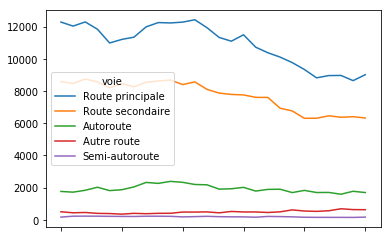

In [28]:
req = df_Accident_type_route.groupby(['voie']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
ruralite,,,,,,,,,,,,,,,,,,,,,
En localité,14915.0,14601.0,15123.0,14635.0,13974.0,14376.0,14329.0,14819.0,15098.0,14966.0,...,13677.0,13372.0,12587.0,12397.0,11574.0,11262.0,11644.0,11742.0,11606.0,11551.0
Hors localité,6601.0,6540.0,6576.0,6378.0,5796.0,5837.0,5866.0,6299.0,6383.0,6549.0,...,5280.0,5251.0,5129.0,4908.0,4754.0,4522.0,4466.0,4412.0,4205.0,4562.0
Sur autoroute,1756.0,1711.0,1828.0,2017.0,1808.0,1862.0,2037.0,2316.0,2256.0,2381.0,...,1779.0,1883.0,1893.0,1685.0,1820.0,1689.0,1693.0,1582.0,1766.0,1686.0


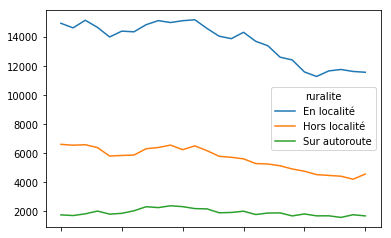

In [29]:
req = df_Accident_type_route.groupby(['ruralite']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
ruralite,,,,,,,,,,,,,,,,,,,,,
En localité,4601.0,4100.0,3872.0,3896.0,3765.0,3632.0,3695.0,3578.0,3512.0,3481.0,...,2829.0,2838.0,2634.0,2665.0,2539.0,2551.0,2587.0,2384.0,2390.0,2260.0
Hors localité,2436.0,2395.0,2290.0,2274.0,1950.0,1978.0,1916.0,2101.0,2074.0,2036.0,...,1578.0,1586.0,1482.0,1500.0,1380.0,1338.0,1264.0,1278.0,1175.0,1179.0
Sur autoroute,480.0,424.0,398.0,451.0,359.0,381.0,414.0,444.0,397.0,437.0,...,295.0,248.0,279.0,257.0,249.0,227.0,196.0,188.0,191.0,207.0


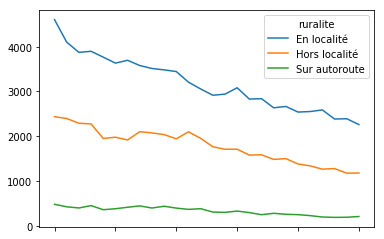

In [102]:
req = df_Accident_type_route[df_Accident_type_route.gravite_index!=315].groupby(['ruralite']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
signalisation,,,,,,,,,,,,,,,,,,,,,
Cédez le passage,2348.0,2143.0,2249.0,2210.0,2017.0,2117.0,2022.0,2193.0,2194.0,2232.0,...,2013.0,1976.0,1861.0,1831.0,1674.0,1602.0,1710.0,1657.0,1707.0,1601.0
Autre priorité,1842.0,1883.0,1873.0,1844.0,1766.0,1783.0,1799.0,1847.0,2079.0,2189.0,...,1952.0,1700.0,1268.0,1151.0,1172.0,1210.0,1416.0,1325.0,1292.0,1295.0
Signalisation lumineuse en service,1240.0,1016.0,1037.0,967.0,849.0,814.0,855.0,867.0,914.0,909.0,...,791.0,658.0,769.0,1130.0,1062.0,1068.0,1117.0,1119.0,1164.0,1160.0
Passage pour piéton,1079.0,1052.0,1071.0,1251.0,1109.0,1103.0,1179.0,1144.0,1209.0,1161.0,...,1066.0,1078.0,1132.0,892.0,860.0,828.0,860.0,844.0,887.0,854.0
Stop,964.0,949.0,898.0,803.0,743.0,728.0,715.0,741.0,720.0,732.0,...,467.0,424.0,370.0,353.0,341.0,365.0,341.0,340.0,339.0,325.0
Priorité de droite,731.0,718.0,739.0,675.0,635.0,641.0,568.0,558.0,583.0,545.0,...,434.0,414.0,414.0,317.0,283.0,279.0,273.0,308.0,304.0,296.0
Priorité au tram / train,115.0,131.0,168.0,133.0,138.0,146.0,115.0,130.0,111.0,129.0,...,115.0,107.0,99.0,53.0,57.0,37.0,70.0,70.0,60.0,73.0
Signalisation des pistes,77.0,58.0,76.0,62.0,63.0,49.0,47.0,54.0,41.0,42.0,...,19.0,40.0,40.0,66.0,55.0,34.0,30.0,31.0,26.0,21.0


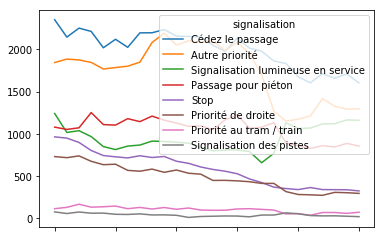

In [35]:
req = df_Accident_type_route[df_Accident_type_route.signalisation_index!=150].groupby(['signalisation']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

In [94]:
total_accident = df_Accident_type_route.groupby(['ruralite']).sum()[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
df_Accident_type_route_normalized_ruralite = df_Accident_type_route.copy()
for ruralite in total_accident.index.values:
    for date in total_accident.columns:
        df_Accident_type_route_normalized_ruralite.loc[df_Accident_type_route_normalized_ruralite.ruralite==ruralite,date] =\
        df_Accident_type_route_normalized_ruralite.loc[df_Accident_type_route_normalized_ruralite.ruralite==ruralite][date]*100/\
        total_accident.loc[total_accident.index==ruralite,date][0]

In [95]:
total_accident

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
ruralite,,,,,,,,,,,,,,,,,,,,,
En localité,14915.0,14601.0,15123.0,14635.0,13974.0,14376.0,14329.0,14819.0,15098.0,14966.0,...,13677.0,13372.0,12587.0,12397.0,11574.0,11262.0,11644.0,11742.0,11606.0,11551.0
Hors localité,6601.0,6540.0,6576.0,6378.0,5796.0,5837.0,5866.0,6299.0,6383.0,6549.0,...,5280.0,5251.0,5129.0,4908.0,4754.0,4522.0,4466.0,4412.0,4205.0,4562.0
Sur autoroute,1756.0,1711.0,1828.0,2017.0,1808.0,1862.0,2037.0,2316.0,2256.0,2381.0,...,1779.0,1883.0,1893.0,1685.0,1820.0,1689.0,1693.0,1582.0,1766.0,1686.0


In [96]:
df_Accident_type_route_normalized_ruralite.loc[df_Accident_type_route_normalized_ruralite.ruralite=='En localité''1992']

,gravite_index,gravite,ruralite_index,ruralite,voie_index,voie,vitesse_index,vitesse,temps_index,temps,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
ruralite,,,,,,,,,,,,,,,,,,,,,
Sur autoroute,72.665148,75.219170,78.227571,77.640059,80.143805,79.538131,79.675994,80.829016,82.402482,81.646367,...,83.417650,86.829527,85.261490,84.747774,86.318681,86.560095,88.422918,88.116308,89.184598,87.722420
En localité,69.151861,71.919732,74.396614,73.378886,73.057106,74.735671,74.213134,75.855321,76.738641,76.740612,...,79.315639,78.776548,79.073647,78.502864,78.062900,77.348606,77.782549,79.696815,79.407203,80.434594
Hors localité,63.096501,63.379205,65.176399,64.346190,66.356108,66.112729,67.337197,66.645499,67.507442,68.911284,...,70.113636,69.796229,71.105479,69.437653,70.971813,70.411322,71.697268,71.033545,72.057075,74.156072


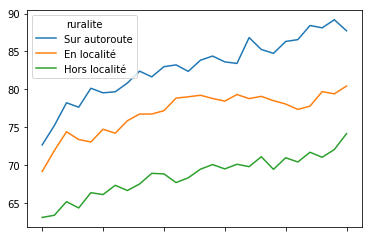

In [98]:
req = df_Accident_type_route_normalized_ruralite[df_Accident_type_route_normalized_ruralite.gravite_index==315].groupby(['ruralite']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

In [114]:
df_Accident_type_route_normalized = df_Accident_type_route.copy()
for date in [col for col in df_Accident_type_route_normalized.columns if IS_DATE.match(col)]:
    df_Accident_type_route_normalized[date] = df_Accident_type_route_normalized[date]*100/(df_Accident_type_route_normalized[date].sum())

In [42]:
req = df_Accident_type_route_normalized.groupby(['gravite']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

NameError: name 'df_Accident_type_route_normalized' is not defined

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
gravite,,,,,,,,,,,,,,,,,,,,,
Accidents avec blessés légers,67.699381,69.722563,72.117142,71.250543,71.850959,72.860702,72.899424,73.871298,74.794624,75.083696,...,77.32446,77.216424,77.586822,76.71406,77.033282,76.443656,77.267876,78.292738,78.631166,79.515703
Accidents avec blessés graves,29.086456,27.384912,25.175330,25.970473,25.544536,24.634202,24.626664,23.785952,22.867254,22.840643,...,21.05517,21.149907,20.816972,21.64297,21.308133,22.085503,21.445824,20.365359,20.185470,19.253891
Accidents mortels,3.214163,2.892526,2.707528,2.778984,2.604505,2.505096,2.473911,2.342750,2.338122,2.075661,...,1.62037,1.633668,1.596206,1.64297,1.658585,1.470841,1.286300,1.341903,1.183365,1.230406


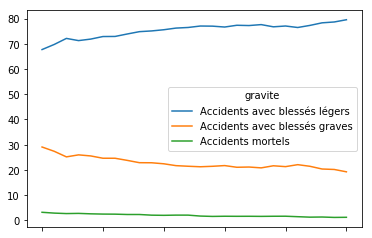

In [132]:
# Part de gravité des accidents par année
df_Accident_type_route_normalized = df_Accident_type_route.copy()
for date in [col for col in df_Accident_type_route_normalized.columns if IS_DATE.match(col)]:
    df_Accident_type_route_normalized[date] = df_Accident_type_route_normalized[date]*100/(df_Accident_type_route_normalized[date].sum())
    
req = df_Accident_type_route_normalized.groupby(['gravite']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
vitesse,,,,,,,,,,,,,,,,,,,,,
70-80 Km/h,1.499656,1.317171,1.211374,1.289622,1.218834,1.159683,1.079525,1.105232,1.095336,0.895547,...,0.752315,0.741246,0.821052,0.753028,0.716332,0.658158,0.606639,0.524357,0.568925,0.584302
90-120 Km/h,0.365246,0.266935,0.255026,0.321320,0.301233,0.244621,0.323858,0.226167,0.198003,0.259458,...,0.125386,0.146299,0.137692,0.105319,0.181838,0.125909,0.095490,0.112765,0.079650,0.112366
60 Km/h,0.124613,0.140032,0.097760,0.091185,0.074150,0.104190,0.080964,0.098148,0.117959,0.075326,...,0.106096,0.068273,0.061196,0.084255,0.060613,0.040062,0.067404,0.056382,0.039825,0.050565
40-50 Km/h,0.034376,0.035008,0.029753,0.052106,0.023172,0.027180,0.013494,0.038406,0.029490,0.025109,...,0.009645,0.024383,0.005100,0.000000,0.016531,0.005723,0.005617,0.016915,0.005689,0.005618
10-30 Km/h,0.000000,0.000000,0.004250,0.000000,0.004634,0.004530,0.008996,0.000000,0.004213,0.004185,...,0.000000,0.004877,0.000000,0.005266,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


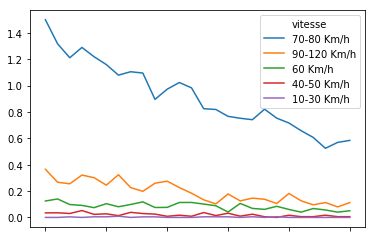

In [139]:
# Circonstance de la route des accidents par année
df_Accident_type_route_normalized = df_Accident_type_route.copy()
for date in [col for col in df_Accident_type_route_normalized.columns if IS_DATE.match(col)]:
    df_Accident_type_route_normalized[date] = df_Accident_type_route_normalized[date]*100/(df_Accident_type_route_normalized[date].sum())
    
req = df_Accident_type_route_normalized[(df_Accident_type_route_normalized.gravite_index==317) & (df_Accident_type_route_normalized.ruralite_index!=10)].groupby(['vitesse']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_type_route.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

## Par cantons

In [141]:
describeDf(df_Accident_cantons)

______________________________ DESCRIPTION ______________________________



         ATTRIBUTE: canton_index
   [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26.]


         ATTRIBUTE: canton
   ['Zürich' 'Bern / Berne' 'Luzern' 'Uri' 'Schwyz' 'Obwalden' 'Nidwalden'
 'Glarus' 'Zug' 'Fribourg / Freiburg' 'Solothurn' 'Basel-Stadt'
 'Basel-Landschaft' 'Schaffhausen' 'Appenzell Ausserrhoden'
 'Appenzell Innerrhoden' 'St. Gallen' 'Graubünden / Grigioni / Grischun'
 'Aargau' 'Thurgau' 'Ticino' 'Vaud' 'Valais / Wallis' 'Neuchâtel' 'Genève'
 'Jura']


         ATTRIBUTE: gravite_index
   [315. 316. 317.]


         ATTRIBUTE: gravite
   ['Accidents avec blessés légers' 'Accidents avec blessés graves'
 'Accidents mortels']


         ATTRIBUTE: ruralite_index
   [10. 11. 12.]


         ATTRIBUTE: ruralite
   ['En localité' 'Hors localité' 'Sur autoroute']


         VALUES: ['1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
canton,,,,,,,,,,,,,,,,,,,,,
Zürich,3102.0,2960.0,3135.0,3081.0,2922.0,3102.0,3097.0,3283.0,3367.0,3400.0,...,3115.0,3225.0,3034.0,3012.0,2940.0,2835.0,3044.0,3202.0,3410.0,3352.0
Bern / Berne,3237.0,3176.0,3234.0,3176.0,3019.0,3058.0,3018.0,3107.0,3053.0,3155.0,...,2732.0,2534.0,2561.0,2630.0,2596.0,2462.0,2509.0,2551.0,2465.0,2616.0
Vaud,2725.0,2620.0,2670.0,2602.0,2349.0,2319.0,2422.0,2573.0,2717.0,2538.0,...,2043.0,2032.0,1981.0,1802.0,1758.0,1782.0,1609.0,1400.0,1692.0,1646.0
Aargau,1547.0,1531.0,1691.0,1576.0,1544.0,1484.0,1431.0,1722.0,1686.0,1708.0,...,1408.0,1464.0,1345.0,1358.0,1250.0,1191.0,1215.0,1213.0,1079.0,1155.0
Genève,1122.0,1084.0,1125.0,1039.0,1033.0,1039.0,1167.0,1222.0,1256.0,1359.0,...,1238.0,1142.0,1108.0,918.0,1023.0,1181.0,1300.0,1264.0,1170.0,1127.0
Luzern,1105.0,1058.0,1057.0,1079.0,1034.0,1142.0,1084.0,1165.0,1187.0,1312.0,...,1135.0,1155.0,1095.0,1107.0,1031.0,967.0,1010.0,1013.0,855.0,979.0
St. Gallen,1310.0,1322.0,1349.0,1263.0,1179.0,1213.0,1274.0,1430.0,1402.0,1439.0,...,1279.0,1331.0,1211.0,1252.0,1210.0,980.0,972.0,911.0,876.0,912.0
Ticino,1771.0,1723.0,1762.0,1708.0,1641.0,1625.0,1551.0,1615.0,1668.0,1635.0,...,1256.0,1154.0,1193.0,1128.0,1050.0,954.0,869.0,904.0,724.0,784.0
Thurgau,682.0,738.0,659.0,612.0,570.0,626.0,657.0,653.0,671.0,692.0,...,682.0,637.0,656.0,666.0,616.0,609.0,632.0,598.0,566.0,614.0


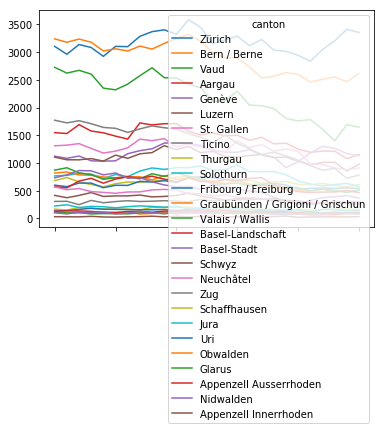

In [142]:
req = df_Accident_cantons.groupby(['canton']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_cantons.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

In [143]:
df_Accident_cantons_normalized = df_Accident_cantons.copy()
for date in [col for col in df_Accident_cantons_normalized.columns if IS_DATE.match(col)]:
    df_Accident_cantons_normalized[date] = df_Accident_cantons_normalized[date]*100/(df_Accident_cantons_normalized[date].sum())
    

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
canton,,,,,,,,,,,,,,,,,,,,,
Zürich,13.329323,12.952914,13.325116,13.378202,13.541570,14.052095,13.930371,14.009559,14.184606,14.228323,...,15.022184,15.727104,15.472487,15.860979,16.200132,16.225033,17.098242,18.053676,19.400353,18.832519
Bern / Berne,13.909419,13.898127,13.745909,13.790708,13.991102,13.852775,13.575027,13.258513,12.861777,13.203047,...,13.175154,12.357359,13.060329,13.849394,14.304607,14.090311,14.093130,14.383175,14.024009,14.697455
Vaud,11.709350,11.465080,11.348663,11.298307,10.886088,10.505096,10.894207,10.979773,11.446265,10.621024,...,9.852431,9.909295,10.102504,9.489205,9.687018,10.198592,9.037803,7.893550,9.626216,9.247711
Aargau,6.647473,6.699632,7.187487,6.843248,7.155436,6.722537,6.436668,7.348297,7.102835,7.147640,...,6.790123,7.139374,6.859095,7.151132,6.887811,6.816231,6.824692,6.839197,6.138704,6.489129
Genève,4.821244,4.743567,4.781740,4.511507,4.787283,4.706682,5.249190,5.214645,5.291317,5.687144,...,5.970293,5.569102,5.650467,4.834123,5.636985,6.759000,7.302140,7.126748,6.656426,6.331816
Luzern,4.748195,4.629792,4.492711,4.685193,4.791918,5.173273,4.875855,4.971409,5.000632,5.490459,...,5.473573,5.632498,5.584171,5.829384,5.681067,5.534253,5.673201,5.711547,4.864311,5.500309
St. Gallen,5.629082,5.785052,5.733838,5.484151,5.463898,5.494904,5.730479,6.102245,5.906391,6.021928,...,6.168017,6.490783,6.175736,6.592944,6.667401,5.608653,5.459754,5.136446,4.983786,5.123883
Ticino,7.610003,7.539821,7.489268,7.416413,7.604968,7.361268,6.976430,6.891696,7.027004,6.842149,...,6.057099,5.627621,6.083941,5.939968,5.785762,5.459852,4.881200,5.096978,4.119019,4.404742
Thurgau,2.930560,3.229477,2.801037,2.657403,2.641579,2.835787,2.955200,2.786549,2.826810,2.895882,...,3.288966,3.106408,3.345403,3.507109,3.394313,3.485377,3.549963,3.371673,3.220117,3.449632


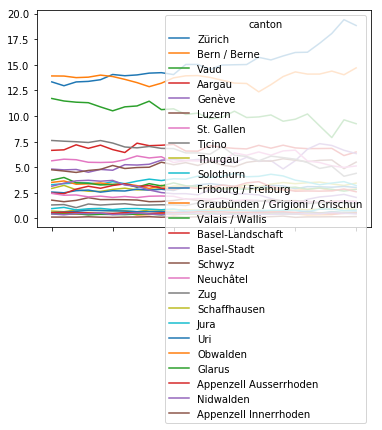

In [145]:

req = df_Accident_cantons_normalized.groupby(['canton']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_cantons.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

In [147]:
total_accident = df_Accident_cantons.groupby(['canton']).sum()[[col for col in df_Accident_cantons.columns if IS_DATE.match(col)]]
df_Accident_cantons_normalized_canton = df_Accident_cantons.copy()
for canton in total_accident.index.values:
    for date in total_accident.columns:
        df_Accident_cantons_normalized_canton.loc[df_Accident_cantons_normalized_canton.canton==canton,date] =\
        df_Accident_cantons_normalized_canton.loc[df_Accident_cantons_normalized_canton.canton==canton][date]*100/\
        total_accident.loc[total_accident.index==canton,date][0]

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
canton,,,,,,,,,,,,,,,,,,,,,
Obwalden,3.539823,5.454545,6.000000,3.191489,6.250000,1.098901,5.042017,2.469136,5.494505,2.678571,...,1.123596,1.818182,6.818182,2.409639,1.250000,3.448276,3.174603,1.515152,1.980198,4.123711
Graubünden / Grigioni / Grischun,4.273504,3.703704,4.198473,2.699229,3.074866,2.872777,3.311258,3.595206,2.446043,2.979275,...,2.622951,2.296820,4.795737,3.231939,3.400000,2.409639,2.851711,3.105590,2.845528,3.732809
Uri,3.731343,4.929577,2.453988,5.978261,4.819277,5.454545,3.750000,4.487179,0.632911,1.875000,...,4.347826,2.013423,1.834862,0.952381,8.490566,4.065041,2.127660,2.564103,1.960784,3.571429
Nidwalden,3.883495,1.219512,0.000000,2.777778,1.769912,0.000000,0.000000,2.362205,0.000000,3.370787,...,0.000000,3.409091,0.000000,0.000000,2.531646,3.658537,2.500000,2.912621,1.098901,2.531646
Neuchâtel,5.096661,3.088803,4.259259,2.886598,2.127660,2.863436,4.612159,3.966597,2.912621,2.862595,...,1.333333,1.662050,1.628664,3.548387,1.689189,2.142857,2.456140,1.063830,2.000000,2.068966
Schwyz,5.288462,5.347594,5.060241,2.569593,3.526448,3.439803,2.211302,1.895735,1.799486,2.015113,...,2.732240,2.873563,3.351955,1.829268,2.539683,1.369863,0.738007,1.677852,1.346801,2.013423
Valais / Wallis,5.510907,4.048140,3.771290,5.443038,4.674221,3.819918,5.073431,4.335664,3.598015,3.557312,...,2.368866,2.495840,3.050847,2.831858,3.783784,3.413655,3.207547,2.970297,2.132196,1.782178
Bern / Berne,2.873031,2.487406,2.442795,2.455919,2.649884,1.831262,2.253148,2.188606,2.129053,1.838352,...,1.537335,1.973165,1.405701,2.319392,1.425270,1.056052,0.916700,1.372011,1.217039,1.414373
Thurgau,3.079179,3.794038,3.945372,4.575163,3.508772,3.993610,3.652968,3.062787,3.427720,2.023121,...,1.319648,1.255887,1.371951,1.801802,1.785714,1.313629,1.107595,1.337793,1.236749,1.302932


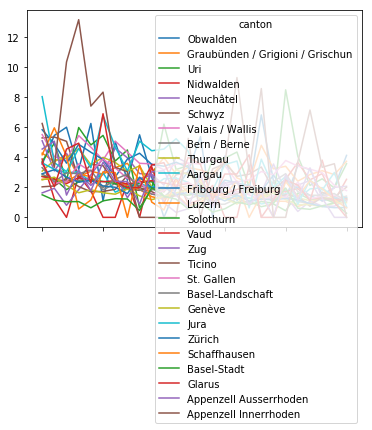

In [153]:
req = df_Accident_cantons_normalized_canton[df_Accident_cantons_normalized_canton.gravite_index==317].groupby(['canton']).sum().sort_values(['2017'], ascending=False)[[col for col in df_Accident_cantons.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

In [207]:
df_Longueur_routes_cantonindex = df_Longueur_routes.copy()
for elem in df_Longueur_routes_cantonindex['canton'].unique():
    try:
        getKeysByValue(dict_cantons, elem)
    except:
        df_Longueur_routes_cantonindex = df_Longueur_routes_cantonindex[df_Longueur_routes_cantonindex.canton!=elem]
df_Longueur_routes_cantonindex['canton'] = [getKeysByValue(dict_cantons, valueToFind) for valueToFind in df_Longueur_routes_cantonindex['canton']]

In [176]:
df_Accident_cantonsindex = df_Accident_cantons.copy()
df_Accident_cantonsindex['canton'] = [getKeysByValue(dict_cantons, valueToFind) for valueToFind in df_Accident_cantonsindex['canton']]

In [224]:
df_Accident_cantonsindex_normalizedkm = df_Accident_cantonsindex.copy().drop(['2017'],axis=1)

for canton in df_Accident_cantonsindex_normalizedkm.canton.unique():
    for date in [d for d in df_Accident_cantonsindex_normalizedkm.columns if IS_DATE.match(d)]:
        df_Accident_cantonsindex_normalizedkm.loc[df_Accident_cantonsindex_normalizedkm.canton==canton,date]=\
        100*df_Accident_cantonsindex_normalizedkm.loc[df_Accident_cantonsindex_normalizedkm.canton==canton,date]/\
        df_Longueur_routes_cantonindex[(df_Longueur_routes_cantonindex.canton == canton) \
                                       & (df_Longueur_routes_cantonindex.annee==int(date))]['Total'].values[0]

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
canton,,,,,,,,,,,,,,,,,,,,,
BS,189.218041,203.466667,222.933333,223.645583,201.494529,210.400000,186.400000,188.000000,169.896469,150.252190,...,135.113485,125.965379,117.709720,94.148936,80.053191,60.372340,79.255319,88.948069,91.611185,99.334221
GE,63.065034,57.975216,63.251901,57.864049,60.004428,61.772935,67.883964,71.418053,74.952143,80.768664,...,69.651009,73.037844,68.620233,65.022091,52.650957,60.162003,69.661267,78.707112,74.933687,69.333923
ZH,31.708863,30.716253,33.320392,31.708863,31.519137,33.183832,32.688551,34.119363,35.547112,35.497348,...,34.200471,32.949400,33.047769,30.961095,31.409214,30.201433,29.133432,31.039611,33.636611,36.189571
ZG,30.366860,30.010530,25.860531,34.599608,30.716724,33.590803,36.285252,31.974133,31.974133,31.794503,...,38.038579,40.021633,38.759690,39.819820,36.936937,30.990991,30.630631,31.491812,33.651251,31.671765
SG,27.817894,28.353700,28.388027,26.156804,25.641906,26.362763,26.874358,29.887025,30.775024,31.438150,...,29.865520,26.896034,28.234501,26.280323,27.931267,23.989218,19.979784,21.052277,19.536513,19.368095


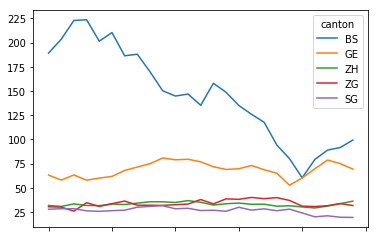

In [231]:
req = df_Accident_cantonsindex_normalizedkm[df_Accident_cantonsindex_normalizedkm.ruralite_index==10].groupby(['canton']).sum().sort_values(['2016'], ascending=False).head(5)[[col for col in df_Accident_cantonsindex_normalizedkm.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
canton,,,,,,,,,,,,,,,,,,,,,
BS,2.935682,2.400000,2.400000,2.135041,1.334401,2.400000,2.133333,2.400000,0.796390,3.185559,...,0.801068,1.331558,0.798935,1.063830,0.797872,1.329787,0.531915,0.532623,0.798935,1.065246
GE,1.822689,1.884195,1.771348,1.033287,1.254705,1.178030,1.178030,1.619791,1.104403,1.104403,...,1.030776,0.809895,1.472537,1.030928,1.104566,0.662739,0.736377,0.809895,0.589449,0.736811
AI,1.438849,0.717360,2.152080,3.597122,1.438849,1.434720,0.717360,0.717360,0.000000,0.000000,...,0.709220,2.836879,0.709220,2.127660,0.000000,0.000000,0.709220,1.418440,0.709220,0.709220
UR,1.085482,1.628223,0.542741,1.899593,1.628223,2.170963,1.356852,1.899593,0.271370,0.809717,...,1.349528,1.349528,0.809717,0.539084,0.269542,2.156334,1.078167,0.269906,0.809717,0.539811
SZ,1.800383,2.249719,2.137233,1.237763,1.462811,1.349831,0.787402,0.899888,0.450096,0.787667,...,1.125239,1.012715,0.900191,1.237345,0.674916,0.893855,0.446927,0.222792,0.445583,0.445583


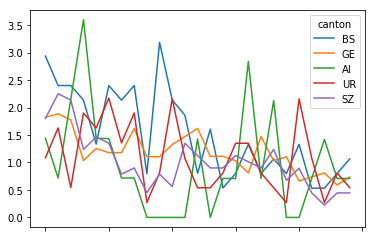

In [239]:
req = df_Accident_cantonsindex_normalizedkm[(df_Accident_cantonsindex_normalizedkm.gravite_index==317) & (df_Accident_cantonsindex_normalizedkm.ruralite_index!=12)].groupby(['canton']).sum().sort_values(['2016'], ascending=False).head(5)[[col for col in df_Accident_cantonsindex_normalizedkm.columns if IS_DATE.match(col)]]
display(req)
req.transpose().plot()

## WHEN?

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
circonstance,,,,,,,,,,,,,,,,,,,,,
Autre facteur d'influence,15441.0,15291.0,16094.0,15570.0,14649.0,15051.0,14853.0,15445.0,15954.0,15776.0,...,13709.0,13528.0,12446.0,12182.0,11400.0,11038.0,11430.0,11293.0,11346.0,11195.0
Alcool,980.0,894.0,896.0,787.0,731.0,735.0,798.0,861.0,787.0,763.0,...,737.0,661.0,658.0,709.0,603.0,555.0,491.0,491.0,439.0,411.0
Drogues,40.0,40.0,49.0,42.0,33.0,46.0,40.0,33.0,46.0,41.0,...,52.0,59.0,63.0,71.0,59.0,46.0,51.0,61.0,53.0,71.0
Alcool + droques,15.0,9.0,12.0,18.0,27.0,18.0,16.0,21.0,15.0,26.0,...,17.0,18.0,28.0,30.0,43.0,29.0,38.0,31.0,35.0,31.0
Médicaments,10.0,11.0,12.0,10.0,8.0,14.0,11.0,13.0,17.0,15.0,...,23.0,32.0,23.0,38.0,29.0,34.0,34.0,41.0,31.0,29.0
Alcool + médicaments,5.0,7.0,4.0,6.0,4.0,3.0,6.0,7.0,8.0,6.0,...,14.0,19.0,17.0,15.0,23.0,25.0,13.0,14.0,9.0,11.0
Drogues et médicaments,7.0,3.0,5.0,4.0,5.0,2.0,5.0,3.0,2.0,5.0,...,2.0,0.0,3.0,5.0,3.0,6.0,7.0,5.0,1.0,5.0
Alcool + drogues + médicaments,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0


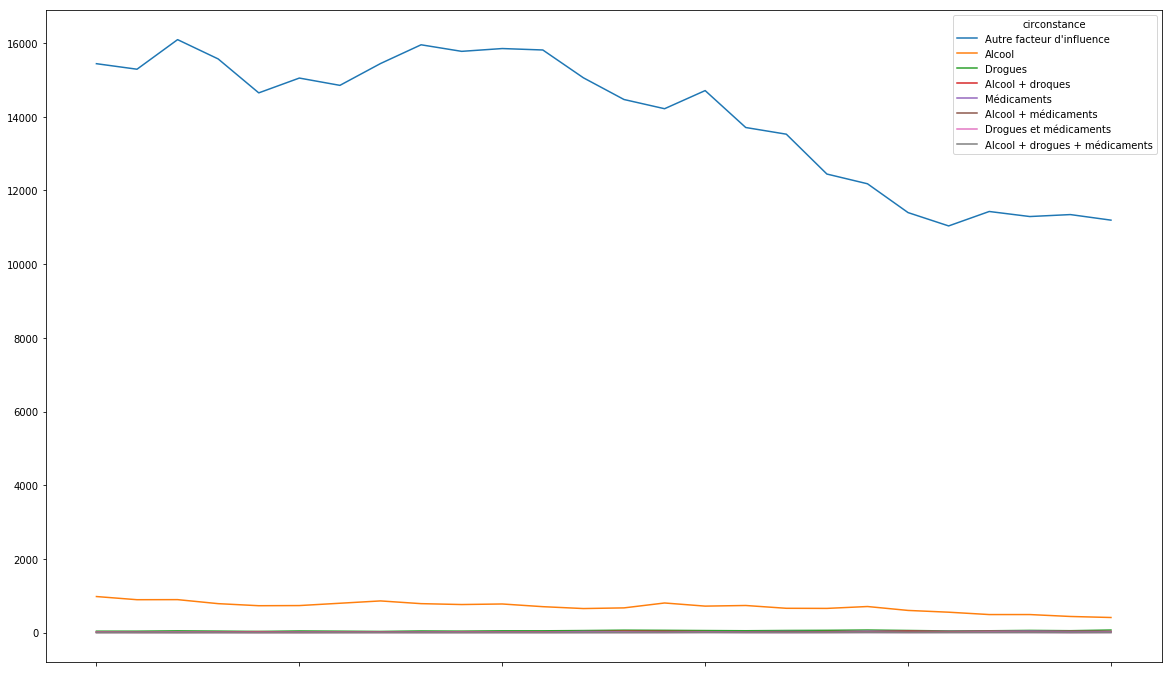

In [39]:
req = df_Accident_circonstances[df_Accident_circonstances.hours_index!=3435].groupby(['circonstance']).sum().sort_values(['2017'], ascending=False)
req = req[[col for col in req.columns if IS_DATE.match(col)]]

display(req)
req.transpose().plot()

# WHAT?

In [45]:
ages = build_age(df_Accident_objets.age_index.unique(),100)
df_Population_2010_trancheAge = df_Population_2010.copy()
for age in ages:
    df_Population_2010_trancheAge[str(age[0])] = df_Population_2010_trancheAge.loc[:,age[1:]].sum(axis=1)

toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
toKeep.append('annee')
toKeep.append('sexe')

df_pop_Suisse = df_Population_2010_trancheAge[(df_Population_2010_trancheAge['canton'] == 'Suisse')\
                                              & (df_Population_2010_trancheAge['sexe'] != 'Sexe - Total')\
                                     & (df_Population_2010_trancheAge.etat_civil == "Etat civil - Total")]

df_pop_Suisse = df_pop_Suisse[toKeep]
df_pop_Suisse['annee'] = df_pop_Suisse['annee'].map(int).map(str)
df_pop_Suisse = df_pop_Suisse.groupby(['annee','sexe']).sum()
df_pop_Suisse = df_pop_Suisse.transpose()
df_pop_Suisse.index = df_pop_Suisse.index.map(float)
df_Suisse_1992 = df_Population_age_1992[(df_Population_age_1992.sexe != 'Sexe - Total') & (df_Population_age_1992.age != 'Age - Total')]
df_Suisse_1992 = df_Suisse_1992.groupby(['age','sexe']).sum().transpose()
ages = build_age(df_Accident_objets.age_index.unique(),99)
for age in ages:
    for s in df_Population_age_1992[df_Population_age_1992.sexe != 'Sexe - Total'].sexe.unique():
        index_to = [(annee,s) for annee in age[1:]]
        df_Suisse_1992[(str(age[0]),s)] = df_Suisse_1992.loc[:,index_to].sum(axis=1)
df_Suisse_1992 = df_Suisse_1992.transpose().reset_index().set_index('age').transpose()

toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
df_Suisse_1992 = df_Suisse_1992[toKeep]
df_Suisse_1992 = df_Suisse_1992.transpose()

for year in range(1992,2010):
    for sexe in np.unique([sexe[1] for sexe in df_pop_Suisse.columns.values]):
        df_pop_Suisse[(str(year),sexe)] = df_Suisse_1992.loc[df_Suisse_1992.sexe==sexe][str(year)]

C:\Users\Clementg20\Anaconda3\lib\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


In [48]:
df_Accident_victimes_normalized = df_Accident_victimes.copy()
df_Accident_victimes_normalized = df_Accident_victimes_normalized[df_Accident_victimes_normalized['sexe_index']!=9]
for year,sexe in df_pop_Suisse.columns.values:
    for age in df_pop_Suisse.index.values:
        df_Accident_victimes_normalized.loc[(df_Accident_victimes_normalized.age_index==age) &\
                                           (df_Accident_victimes_normalized.sexe==sexe),year]\
        = df_Accident_victimes_normalized[year]*10000 / df_pop_Suisse.loc[df_pop_Suisse.index==age,year][sexe].values[0]

df_Accident_victimes_normalized = df_Accident_victimes_normalized[df_Accident_victimes_normalized.age_index != 999]

req = df_Accident_victimes_normalized[(df_Accident_victimes_normalized.role=='Piéton') & (df_Accident_victimes_normalized.consequence_index==320.0) ].groupby(['age']).sum().sort_values(['2017'], ascending=False)
req = req[[col for col in req.columns if IS_DATE.match(col)]]
display(req)


,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
age,,,,,,,,,,,,,,,,,,,,,
70 ans et +,2.377765,2.005036,2.033568,1.808933,1.572686,1.558782,1.588198,1.274394,1.817618,1.354294,...,0.729640,0.570384,0.639931,0.720765,0.676877,0.869414,0.337838,0.638013,0.405874,0.390141
60-69 ans,0.635827,0.515737,0.258539,0.584370,0.278894,0.413416,0.257678,0.366059,0.394381,0.393208,...,0.148267,0.266386,0.235274,0.162523,0.229422,0.134310,0.156861,0.132769,0.044672,0.174291
18-19 ans,0.119444,0.117189,0.365915,0.121757,0.127717,0.486736,0.240746,0.365043,0.231495,0.000000,...,0.000000,0.104351,0.209997,0.000000,0.000000,0.106210,0.105424,0.000000,0.112985,0.114424
jusqu'à 4 ans,0.145923,0.287136,0.464326,0.229971,0.474166,0.384586,0.388491,0.298404,0.346729,0.208265,...,0.055134,0.268306,0.148444,0.099658,0.201844,0.046940,0.097643,0.091048,0.232426,0.091718
21-29 ans,0.117233,0.020220,0.123051,0.126796,0.131419,0.022910,0.094252,0.144826,0.097790,0.024001,...,0.000000,0.088481,0.063712,0.084042,0.102765,0.040335,0.099836,0.059093,0.119041,0.079749
30-39 ans,0.142197,0.070683,0.069122,0.117555,0.082809,0.132134,0.049442,0.182514,0.099811,0.131321,...,0.089424,0.071750,0.089872,0.071395,0.122321,0.052346,0.000000,0.000000,0.116407,0.065637
50-59 ans,0.205519,0.176959,0.197736,0.144284,0.141047,0.321524,0.336328,0.109658,0.279489,0.296478,...,0.079010,0.058599,0.246641,0.092521,0.178877,0.085898,0.050063,0.098472,0.063935,0.046566
40-49 ans,0.235576,0.136705,0.118073,0.138011,0.039123,0.135570,0.252566,0.133445,0.113711,0.128769,...,0.095477,0.031228,0.061372,0.076766,0.015650,0.046446,0.062443,0.094274,0.031905,0.032236
10-14 ans,0.000000,0.154165,0.000000,0.048161,0.098423,0.000000,0.094502,0.333975,0.137620,0.000000,...,0.000000,0.092701,0.049106,0.047279,0.047753,0.000000,0.048291,0.000000,0.000000,0.000000


In [43]:
df_Accident_victimes

,voiture_index,voiture,sexe_index,sexe,role_index,role,age_index,age,consequence_index,consequence,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,0.0,jusqu'à 4 ans,315.0,Blessé léger,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,0.0,jusqu'à 4 ans,316.0,Blessé grave,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,0.0,jusqu'à 4 ans,320.0,Tué,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,5.0,5 ans,315.0,Blessé léger,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,5.0,5 ans,316.0,Blessé grave,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,5.0,5 ans,320.0,Tué,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,6.0,6-9 ans,315.0,Blessé léger,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,6.0,6-9 ans,316.0,Blessé grave,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,6.0,6-9 ans,320.0,Tué,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,210.0,Voiture de tourisme,1.0,Homme,300.0,Conducteur,10.0,10-14 ans,315.0,Blessé léger,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
'a_b_c_d_e'.split('_',2)

['a', 'b', 'c_d_e']

In [31]:
df_test = pd.DataFrame([[4,59,392,439,43,43,43,43,59,59,59,59,59,59,59,59,59],[4,59,392,439,43,43,43,43,59,59,59,59,59,59,59,59,59]]).transpose()

In [34]:
df_test = df_test.groupby(0).count().reset_index()
df_test

,0,1
0,4,1
1,43,1
2,59,1
3,392,1
4,439,1


In [39]:
df_test[0] = df_test[0].apply(lambda x : 1 if x<100 else 10)

In [47]:
res = df_test.groupby(0).count().reset_index()
res[res[0] == 1][1].values[0]

3